# Salary Prediction ML Algorithm
## Data Translation Challenge 
### OMSBA 5067 Spring 2021
### Author: Jennifer Grosz

**_Abstract:_** *A prediction is statement about what will happen or might happen in the future. Future events are unknown and, in many cases, confirmed, exact data about the future is impossible to obtain. This makes predictions useful tools for the determination of and preparation for probable future outcomes. In this paper, observations containing historical person-level data and salary information will be used as the basis for a comparative analysis between six machine learning models’ salary prediction capabilities. Machine Learning models discussed in this paper include Multiple Linear Regression, Polynomial Regression, K-Nearest Regressor, Random Forest Regressor, Ridge Regression and Lasso Regression algorithms.*

### Introduction

**Problem Statement:** The purpose of this analysis is to determine the best Machine Learning algorithm for predicting a person’s prospective salary based on existing data. Use cases for these models include predicting the salary for a business’ newly hired employee or predicting the salary for a business professional job posting online where the anticipated salary information is not provided; it can also be used as an algorithm to predict your own salary. The prediction algorithms used for this analysis take certain key features as inputs and produce the most accurate salary predictions based on the previous data each model was trained with. 

This analysis achieves the goal of identifying the best salary prediction algorithm by using person-level data between 2016 and 2020 extracted from the Integrated Public Use Microdata Series - Current Population Survey (IPUMS CPA). The features that will be used to predict salay in this analysis included region name, age, sex, education, years_experience, and Position. The target variable from this data set is earnings.

**Motivations:** The inspiration behind this paper stems from personal frustrations experienced stemming from the lack of information about expected salary figures provided to prospective applicants during the online job search and application process. Additionally, this analysis is being utilized as an opportunity to further explore and apply machine learning algorithms to develop a deeper personal understanding of learned algorithms and the process for evaluating their performance results.

In [1]:
#import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn import metrics
from scipy.stats import norm, skew
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_absolute_error, explained_variance_score
import plotly.graph_objects as go

# Data Analysis

The following is an overview of tidying that was done using R-studio to the origional data extract which resulted in the final CSV file used for this analysis.

The data set was initially filtered to only include respondents with the following critera:
- currently active in the labor force
- currently employed 
- more than 0 hours worked in the last week
- have a specified number of hours worked per week
- have a specified metro area
- have income wage data
- age beween 18 and 65
- perosnal income/wages less than 600,000 USD per year
- earning equal to or greater than the federal minimum wage of 7.25 USD per hour
- highschool graduate and higher education levels
- less than 40 years of work experience

Then, the data set was filtered to select only respondents with coded occupations that fall into the following occupation categories. The purpose for this selection was to narrow the scope of this ML analysis to predict the salary for prospective job applicants seeking work in a business professional role. Occupation categories include:
- Business Operations
- Computer, Mathematical
- Management
- Office, Administrative Support
- Sales & Related

Finally, the respondants' coded occupation value in the data extrated from IPUMS CPA were grouped into the following 23 Position title categories which were used in this analysis:
- Bookkeeping/Billing
- Business Analyst
- Business Manager
- Chief Executive
- Computer Netowrking
- Computer Programmer
- Computer Systems Administrator
- Customer Service Representative
- Database Administrator
- Human Resources
- Human Resources Manager
- IT Analyst
- IT other
- Marketing Manager
- Office Manager
- Operations Manager
- Purchasing Manager
- Receptionist
- Sales Agent
- Sales Manager
- Secretary
- Technical Support Specialist
- Web/Software Developer

The feature years_experience (represending years of work experience) was created by subtracting the respondent's age of completing age of completing their highest level of education from their current age. This is a common technique used for estimating years of experience as this is not a variable tracked by any of the Integrated Public Use Microdata Series surveys.


##### Loading the tidy data set. 

In [2]:
df = pd.read_csv("salary_data.csv").dropna()

##### Look at the data

In [3]:
# verify data
#print(df.head(5))
# Summary of data 
print(df.info())
# Shape of data
#print(df.shape)
# Summary Statistics
#print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35359 entries, 0 to 35358
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   region_name       35359 non-null  object 
 1   age               35359 non-null  int64  
 2   sex               35359 non-null  object 
 3   education         35359 non-null  object 
 4   years_experience  35359 non-null  int64  
 5   Position          35359 non-null  object 
 6   earnings          35359 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 2.2+ MB
None


## Target Variable: Earnings

For this analysis, the target variable is "earnings". Below is a visualization of the distribution of earnings over the 35,359 observations included in the data.

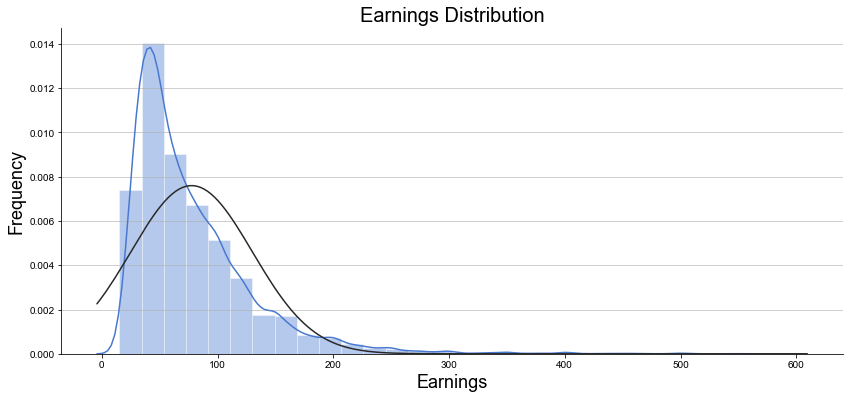

In [4]:
plt.figure(figsize=(14,6))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
sns.set(style="white", palette="muted", color_codes=True)
sns.distplot(df["earnings"], bins = 30,fit = norm, kde = True, color = 'b')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Earnings', size = 18)
plt.ylabel('Frequency', size = 18)
plt.title('Earnings Distribution', size = 20)
plt.plot()
plt.show()

The dark blue line is the actual curve of the earnings' distribution in this data set and the black line is the normalized distribution curve. They differ significantly. 

In [5]:
print('The skew of the earnings distribution is = ', skew(df["earnings"]))

The skew of the earnings distribution is =  2.264003803159532


As shown above, the earnings variable in this data set has a skewed distribution. While this right-tailed distribution would typically be a concern for the statistical analysis of a linear regression model; this assumption violation is not a concern here because this is a Machine Learning problem. Thus, for this ML prediction algorithm perofrmance analysis the response variable (earnings) will not undergo a log transofrmation as that would alter the interpretation of performance results generated by the models below.



# Features

The features contained in this data set have numeric and categorical values. For the numeric data types, the following three plots have been generated to visualize each feature: 
- distribution of observations per feature
- a fitted line of regression between the feature and earnings 
- variance of the feature's line of fit with earnings

Similar to the earnings distribution above, these plots show the distribution of observations in the data set per feature value. The fitted line of regression is used to visualize the linear relationship between the feature and the earnings variable and variance has been plotted to show how much the data varies from that fitted line. 

The categorical variables have been visualized with two plots:
- count of observations per category for each feature
- violin plot showing earnings per category for each feature

The bar plots are used to visualize the distribution of each categorical feature in the data set and voilin plots have been generated to visualize the shape of the earnings variable's distribution per category for each feature. 

## Feature: Age (years)

The skew of the Age distribution is =  0.030300848592257474 



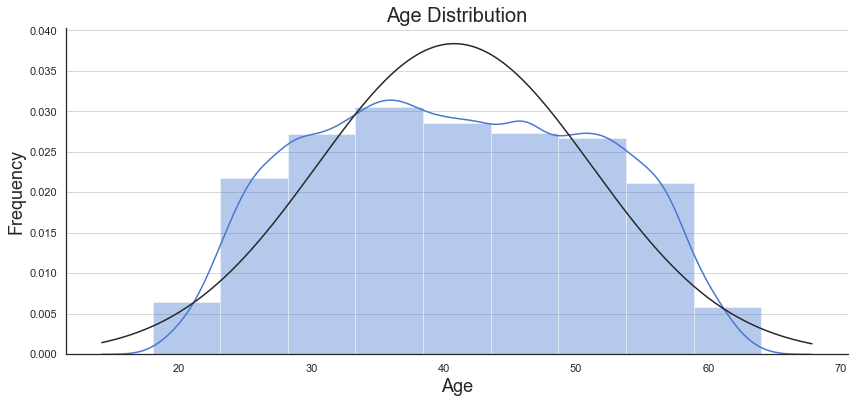

In [6]:
plt.figure(figsize=(14,6))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
sns.set(style="white", palette="muted", color_codes=True)
sns.distplot(df["age"], bins = 9, fit = norm, kde = True, color = 'b')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Age', size = 18)
plt.ylabel('Frequency', size = 18)
plt.title('Age Distribution', size = 20)
plt.plot()
print('The skew of the Age distribution is = ', skew(df["age"]), "\n")

The distribution of age in this data set is normal.

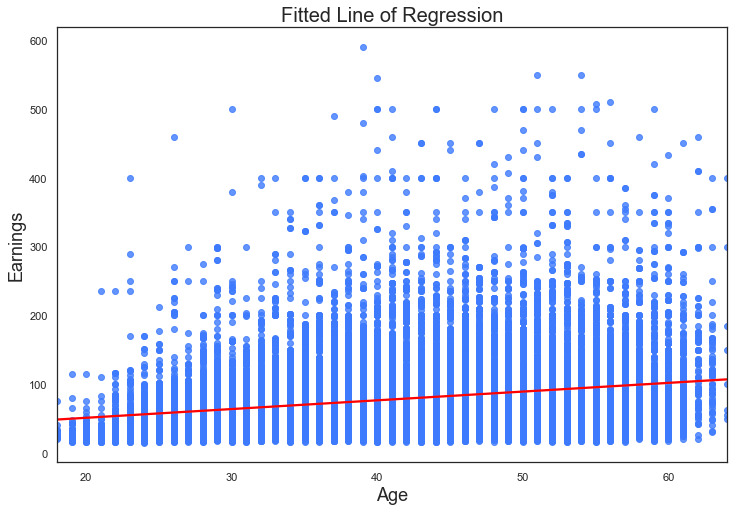

In [7]:
plt.figure(figsize=(12,8))
sns.regplot(x=df.age, y = df.earnings, 
            data = df, line_kws = {'color' : 'red'},
              color='xkcd:lightish blue')  
plt.ylabel('Earnings', size = 18)
plt.xlabel('Age', size = 18)
plt.title('Fitted Line of Regression', size = 20)
plt.show()

There is a clear linear relationship between age and earnings. Using a linear regression model for this feature makes sense given this positive linear relationship.

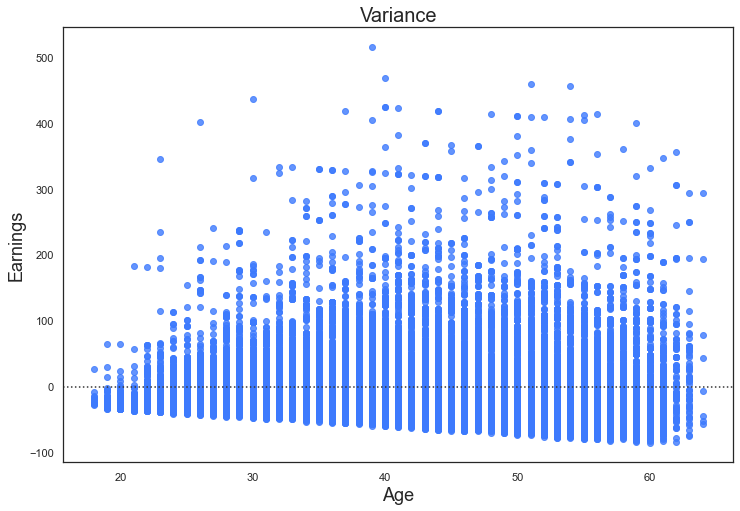

In [8]:
plt.figure(figsize=(12,8))
sns.residplot(x=df.age, y = df.earnings, data = df,
              line_kws = {'color' : 'red'},
              color='xkcd:lightish blue')  
plt.ylabel('Earnings', size = 18)
plt.xlabel('Age', size = 18)
plt.title('Variance', size = 20)
plt.show()

Variance in earnings seems to increase with age.

## Feature: Work Experience (years)

The skew of the Work Experience distribution is =  0.061934969933698056 



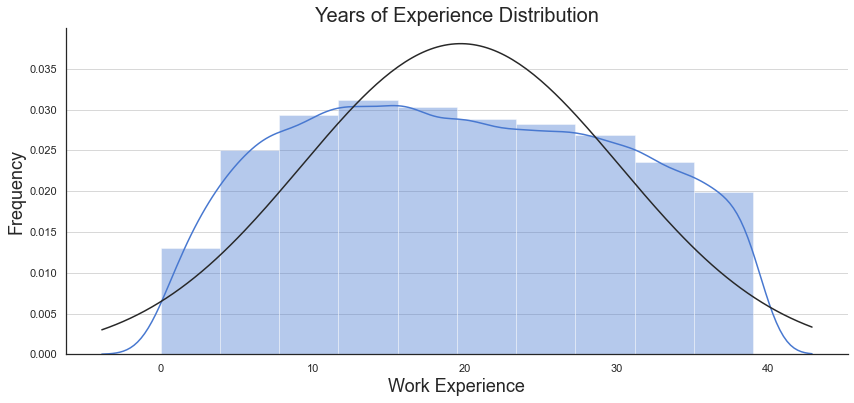

In [9]:
plt.figure(figsize=(14,6))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
sns.set(style="white", palette="muted", color_codes=True)
sns.distplot(df["years_experience"], bins = 10, fit = norm, kde = True, color = 'b')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Work Experience', size = 18)
plt.ylabel('Frequency', size = 18)
plt.title('Years of Experience Distribution', size = 20)
plt.plot()
print('The skew of the Work Experience distribution is = ', skew(df["years_experience"]), "\n")

Work experience seems to have a reasonably normal distribution.

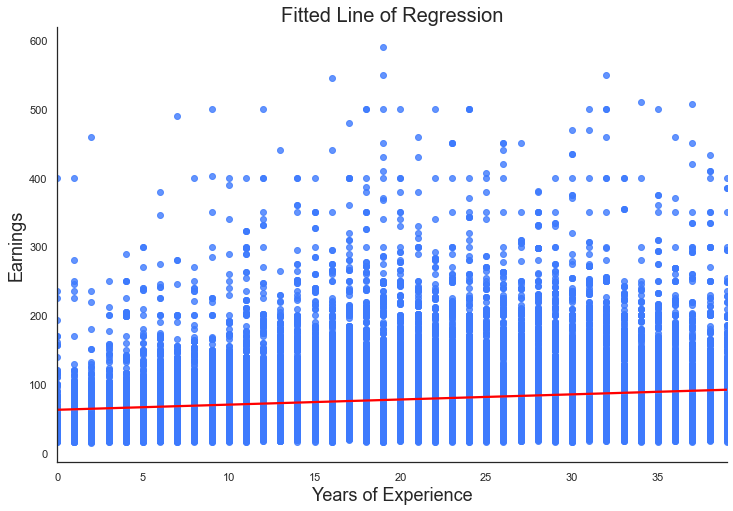

In [10]:
plt.figure(figsize=(12,8))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
sns.regplot(x=df.years_experience, y = df.earnings, 
            data = df, line_kws = {'color' : 'red'},
            color='xkcd:lightish blue')  
plt.ylabel('Earnings', size = 18)
plt.xlabel('Years of Experience', size = 18)
plt.title('Fitted Line of Regression', size = 20)
plt.show()

There appears to be a slightly positive linear relationship between years of experience and earnings.

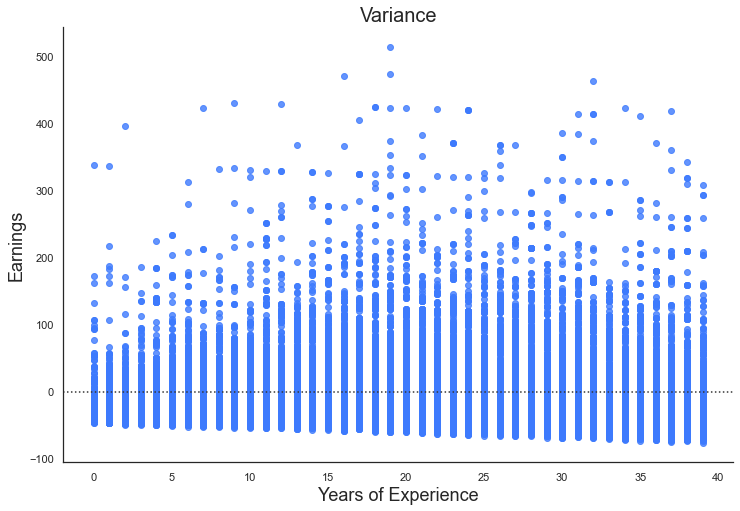

In [11]:
plt.figure(figsize=(12,8))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
sns.residplot(x=df.years_experience, y = df.earnings, data = df,
              line_kws = {'color' : 'red'},
              color='xkcd:lightish blue')  
plt.ylabel('Earnings', size = 18)
plt.xlabel('Years of Experience', size = 18)
plt.title('Variance', size = 20)
plt.show()

Similar to the variance plot for age and earnings, the variance in earnings seems to increase with years of work experience.

## Feature: Region Name

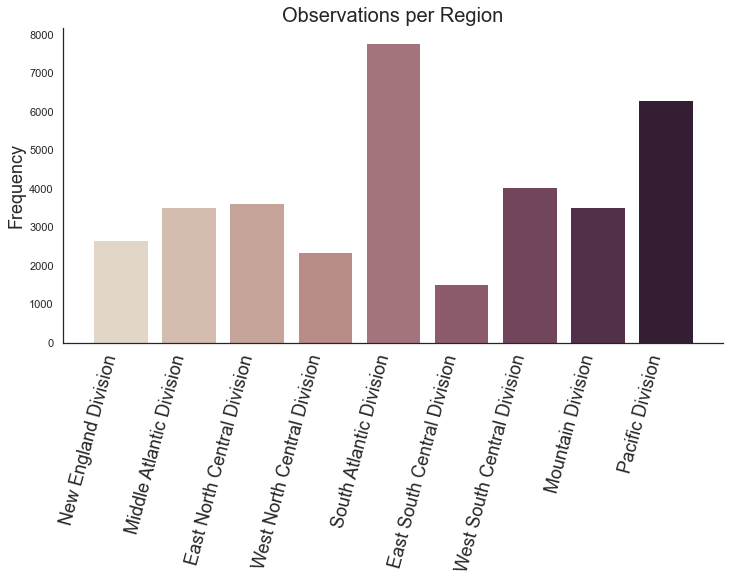

In [12]:
sns.catplot(x="region_name", kind="count", palette="ch:.25",
            data=df, height=5, aspect=2)
plt.xticks(rotation = 75, size = 18, ha="right")
plt.ylabel('Frequency', size = 18)
plt.title('Observations per Region', size = 20)
plt.xlabel('')
plt.plot()
plt.show()

The frequency of observations per region is not ideal as the number of observations from the South Atlantic Division are more than double the number of observations from the East South Central Division. While this is not ideal, there are still more than 1000 observations present in the dataset from the East South Central Division, so it's safe to assume that the dataset has enough datapoints from that region to be split and trained properly to predict salaries from that region.

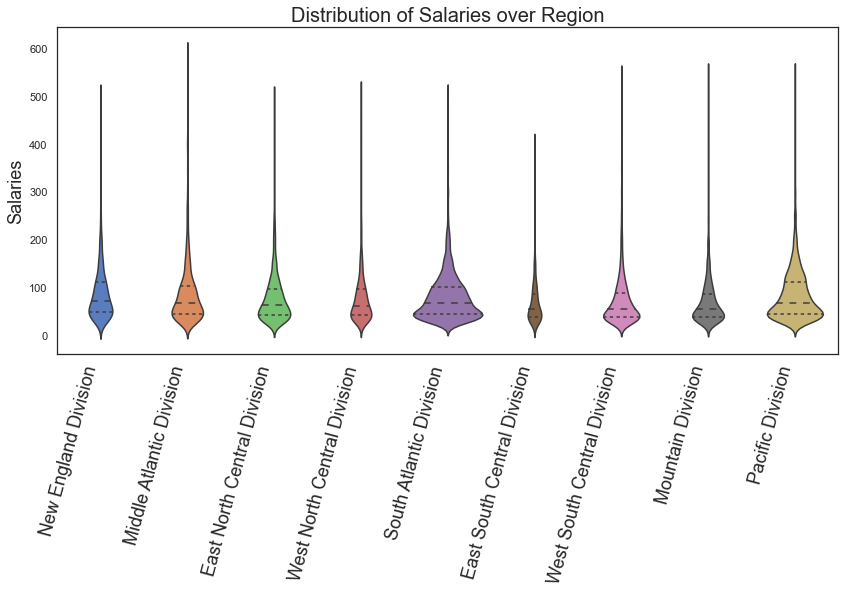

In [13]:
plt.figure(figsize=(14,6))
sns.violinplot(x = df.region_name, y = df.earnings, 
               data = df, scale = 'count', inner = 'quartile')
plt.xticks(rotation = 75, size = 18, ha="right")
plt.ylabel('Salaries', size = 18)
plt.xlabel('')
plt.title('Distribution of Salaries over Region', size = 20)
plt.show()

Given the frequency of observations from each region plotted above, this violin plot of earnings seems to accurately reflect the expected distribution of earnings per region.

## Feature: Sex

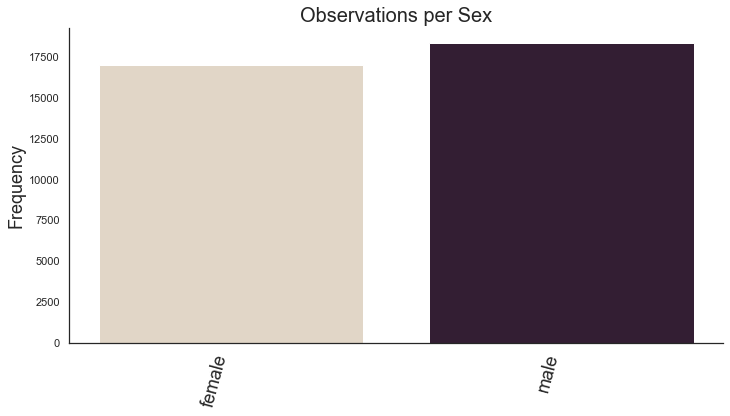

In [14]:
sns.catplot(x="sex", kind="count", palette="ch:.25",
            data=df, height=5, aspect=2)
plt.xticks(rotation = 75, size = 18, ha="right")
plt.ylabel('Frequency', size = 18)
plt.title('Observations per Sex', size = 20)
plt.xlabel('')
plt.plot()
plt.show()

The number of observations for male and female seem to be evenly distributed.

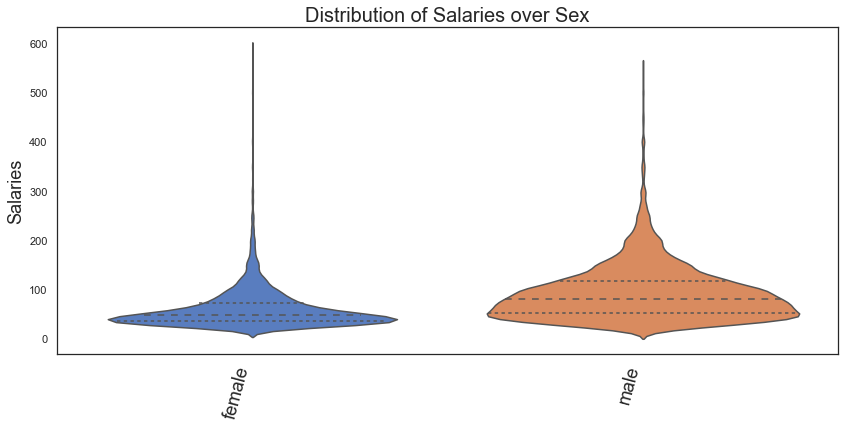

In [15]:
plt.figure(figsize=(14,6))
sns.violinplot(x = df.sex, y = df.earnings, 
               data = df, scale = 'count', inner = 'quartile')
plt.xticks(rotation = 75, size = 18, ha="right")
plt.ylabel('Salaries', size = 18)
plt.xlabel('')
plt.title('Distribution of Salaries over Sex', size = 20)
plt.show()

The distribution of earnings is much hiher for males than females and this indicates that this will be a useful feature to include for the models to be trained with in order to accurately make earnings predictions.

## Feature: Education

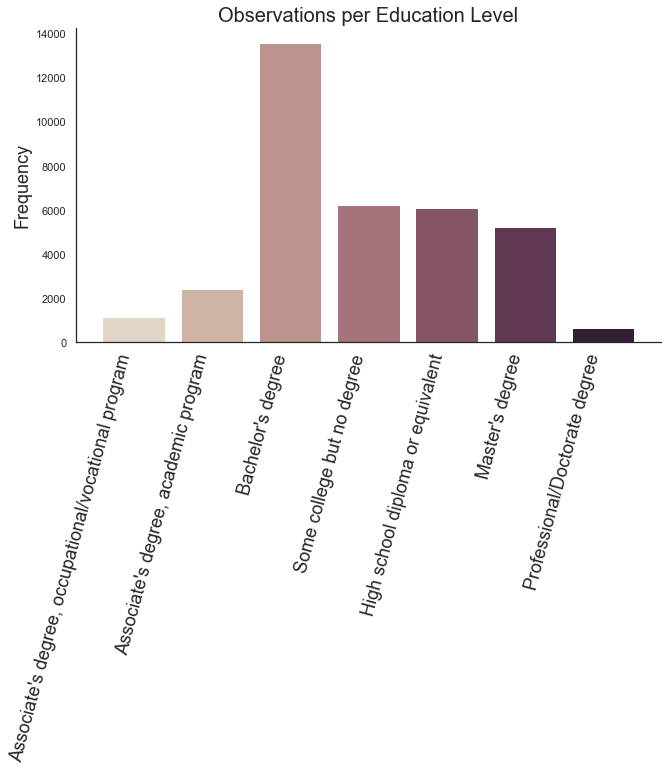

In [16]:
sns.catplot(x="education", kind="count", palette="ch:.25",
            data=df, height=5, aspect=2)
plt.xticks(rotation = 75, size = 18, ha ='right')
plt.ylabel('Frequency', size = 18)
plt.title('Observations per Education Level', size = 20)
plt.xlabel('')
plt.plot()
plt.show()

The low number of observations in the dataset for people with professional and doctorate degrees is an indication that the model may have a difficult time predicting salaries for people with that level of education will since they will not have many observations with that education level to be trained with.

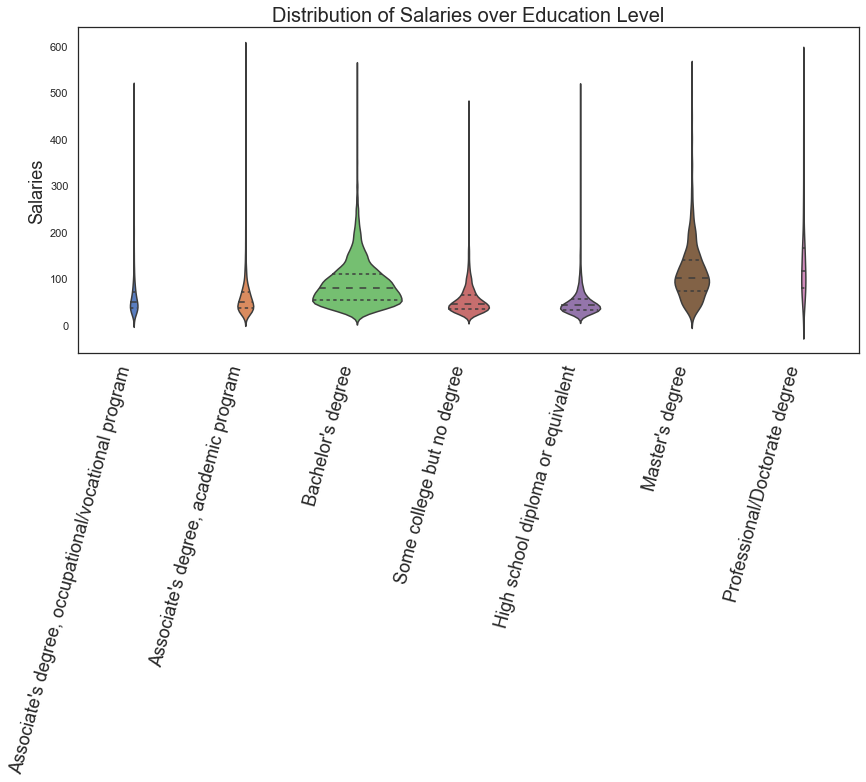

In [17]:
plt.figure(figsize=(14,6))
sns.violinplot(x = df.education, y = df.earnings, 
               data = df, scale = 'count', inner = 'quartile')
plt.xticks(rotation = 75, size = 18, ha="right")
plt.ylabel('Salaries', size = 18)
plt.xlabel('')
plt.title('Distribution of Salaries over Education Level', size = 20)
plt.show()

Given the frequency of observations from each education level plotted above, this violin plot of earnings seems to accurately reflect the expected distribution of earnings per highest educational attainment.

## Feature: Position

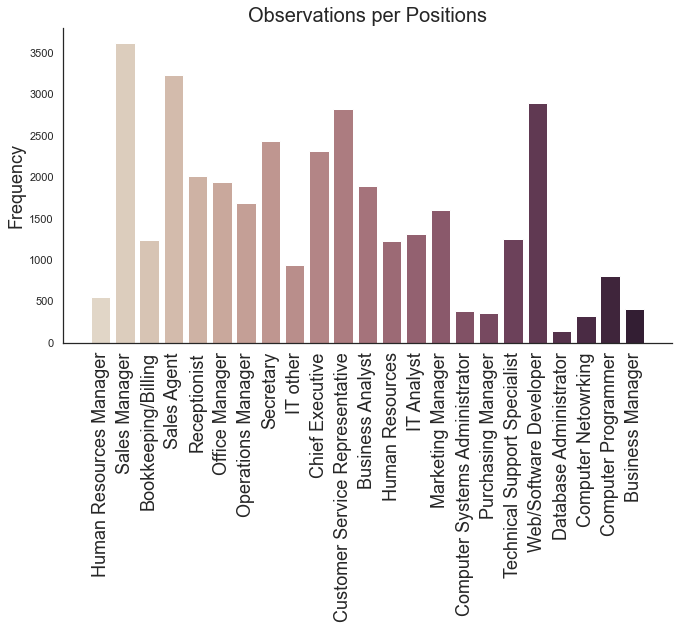

In [18]:
sns.catplot(x="Position", kind="count", palette="ch:.25",
            data=df, height=5, aspect=2)
plt.xticks(rotation = 90, size = 18, ha ='center')
plt.ylabel('Frequency', size = 18)
plt.title('Observations per Positions', size = 20)
plt.xlabel('')
plt.plot()
plt.show()

This plot shows there is a low count of observations for people whose positions are categorized as database administrators, purchasing maangers, computer systems administrators and computer networking. This is indication that the model may have a difficult time predicting salaries for people in these positions since there will not be many observations with that position for the models to be trained on.

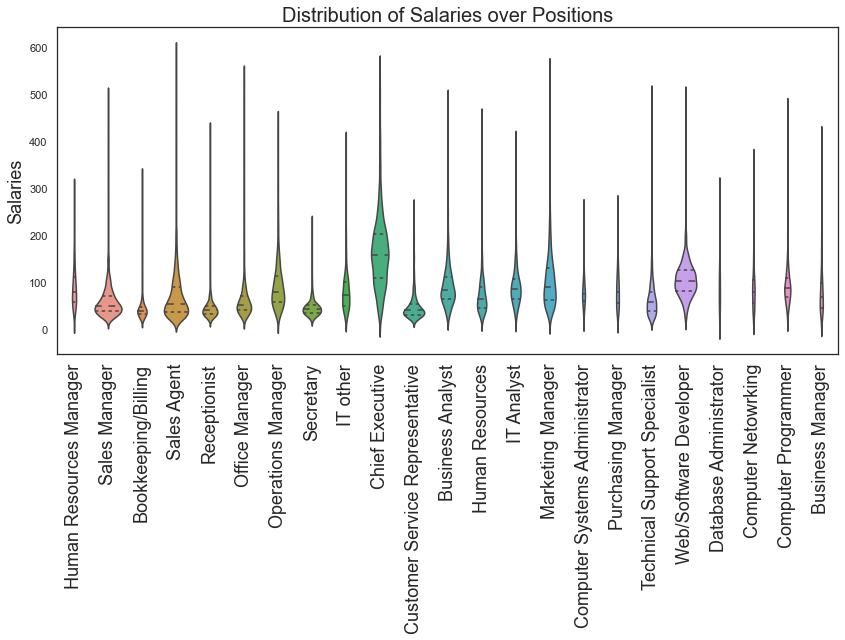

In [19]:
# violin plot
plt.figure(figsize=(14,6))
sns.violinplot(x = df.Position, y = df.earnings, 
               data = df, scale = 'count', inner = 'quartile')
plt.xticks(rotation = 90, size = 18, ha="center")
plt.ylabel('Salaries', size = 18)
plt.xlabel('')
plt.title('Distribution of Salaries over Positions', size = 20)
plt.show()

Given the frequency of observations from each Position plotted above, this violin plot of earnings seems to accurately reflect the expected distribution of earnings per job position.

# Machine Learning Models

##### Evaluation Metrics:
- R-squared: measures how much of the variation in outcome can be explained by the variation in the independent variables.
- Mean Squared Error: measures how close a regression line is to a set of actual points. Calculated as the average squared difference between the estimated values and the actual value.
- Mean Average Error: measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.
- Root Mean Squared Error: measures the average magnitude of the error using a quadratic scoring rule that gives a relatively high weight to large errors.
- Explained Variance: similar to R-squared, explained variance measures how much variation in outcomes can be explained by variation in the independent variables, except R-squared assumes that changes in the dependent variable are due to a linear relationship with the independent variable whereas explained variance does not have this underlying assumption.

The following machine learning models' performance will be evaluated based on the metrics listed above.

##### Machine Learning Models:
This analysis is conducted using the following machine learning models.
- Multiple Linear Regression
- Polynomial Regression
- K-Nearest Neighbors
- Random Forest Regression
- Ridge Regression
- Lasso Regression

These models have been selected based on insights gained during a literature review and for experimental purposes of learning more about ML algorithms learned about in the OMSBA 5067 ML course.

##### Tuning and Training The Models:
There are many different methods one can use for handling categorical data when implementing regression algorithms. For each ML model, a performative analysis will be conducted in order to determine the optimal method for handling categorical data. The methods tested for each ML aglorithm include:
- Ordinal (number) encoding: - each unique category value is assigned an numeric float value.
- Dummy encoding: - each categorical variable is removed and a new binary variable is added for each unique categorical value.

In order to identify optimal settings the following additional model tuning has been conducted:
- Polynomial regression algorithm using number-coded data has been tuned with degrees parameter = (2, 3, 4, 5, 6, 7)
- KNN regression algorithm has been tuned with n_neighbor parameters = (1,2,3,4,5,6,7,8,9,10,20,30,50,100,200,300)
- Random Forest regression algorithm has been tuned with n_estimator parameters = (10, 50, 100, 150, 200, 250, 300)
    
Once optimal parameter values have been identified, all models will additionally be trained using 10-fold cross validation prior to the final prediction test.

##### Testing The Models:
To implement this process, the entire data set will initially be split (80/20) into training and test data sets. The 80% training data from this initial split is used for tuning and training of the models. Once optimal model parameters and categorical data encoding methods have been identified, a final comparative test will be ran using the 20% test data and the best-performing version of each machine learning algorithm. The resulting test data from the initial split will not be used during the tuning or training process, it is separated and only used only in a final test.

## Feature Selection

### Number Encoding

The ordinal encoded data set is created using the LabelEncoder function from the Sklearn package. Then feature selection is performed by creating a correlation matrix.

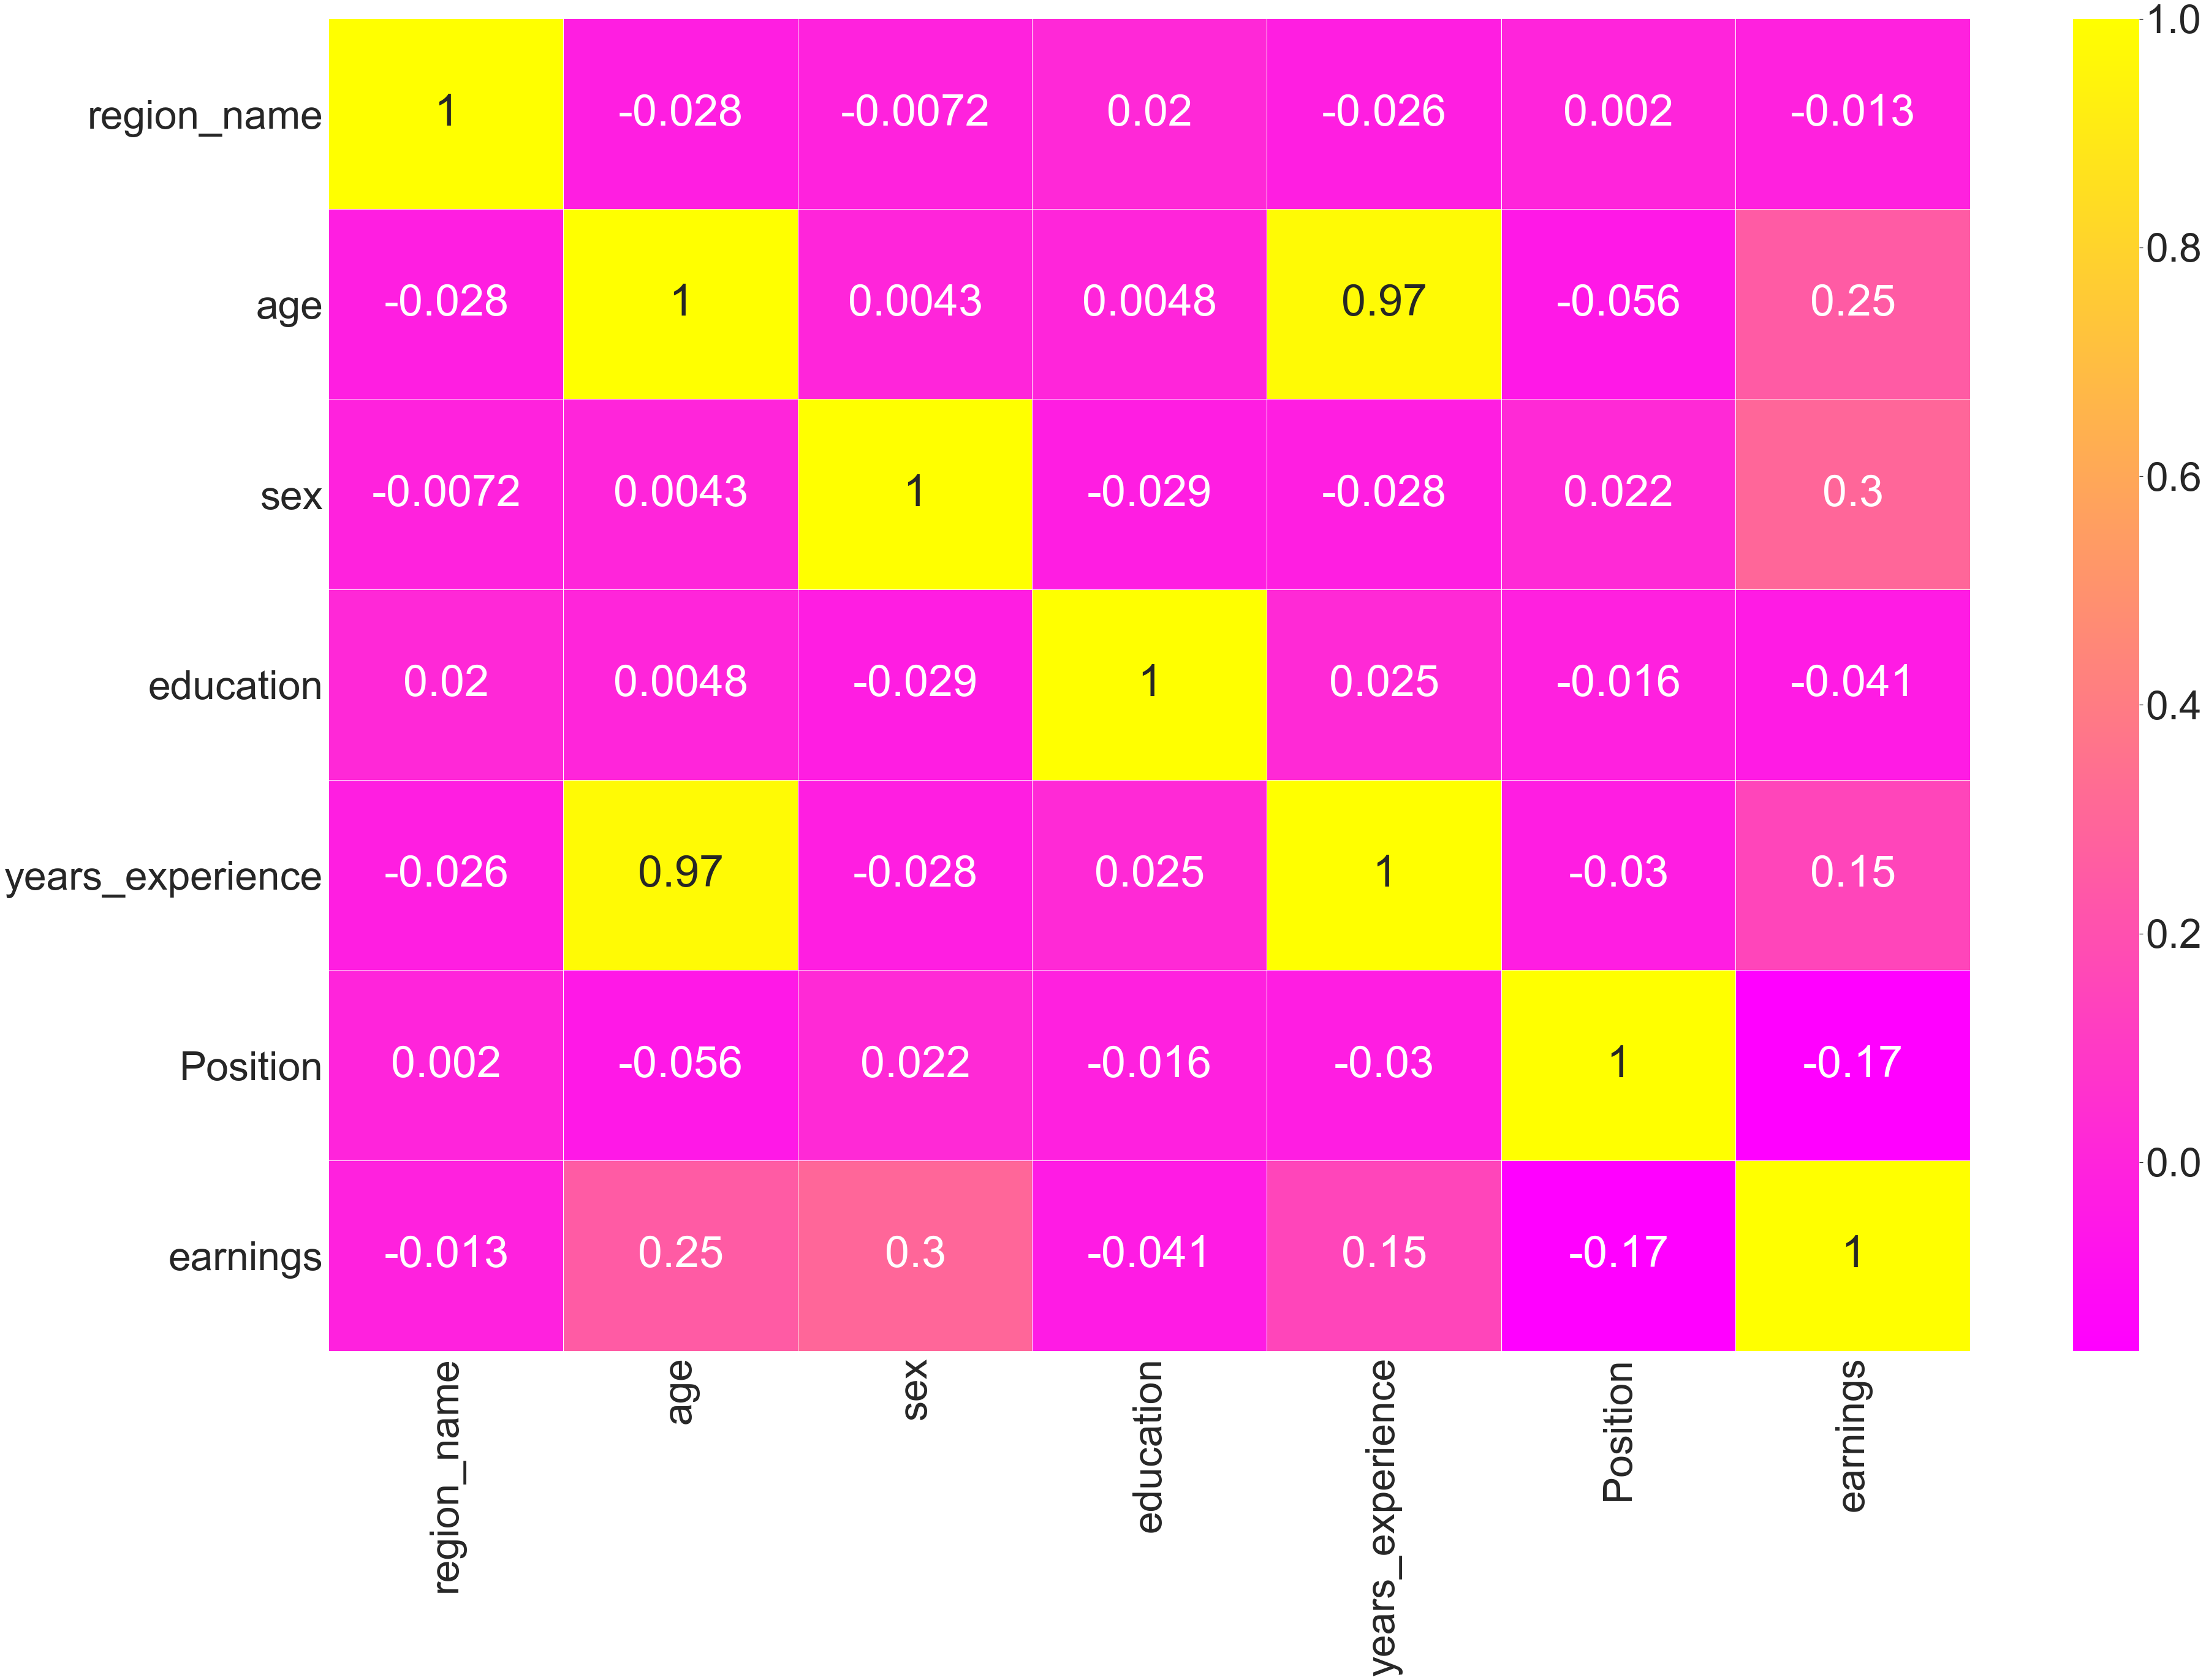

In [20]:
# Copy df
num_df = df.copy()
label_encoder = LabelEncoder()
# numeric code categorical data
# region_name
num_df.iloc[:,0] = label_encoder.fit_transform(num_df.iloc[:,0]).astype('float64')
# sex
num_df.iloc[:,2] = label_encoder.fit_transform(num_df.iloc[:,2]).astype('float64')
# education
num_df.iloc[:,3] = label_encoder.fit_transform(num_df.iloc[:,3]).astype('float64')
# position
num_df.iloc[:,5] = label_encoder.fit_transform(num_df.iloc[:,5]).astype('float64')
# Plot heatmap of all data with correlation coefficients visible
############################### CORRELATION MATRIX ELIMINATION
corr = num_df.corr()
sns.set(font_scale = 6)
plt.subplots(figsize=(60,40))
sns.heatmap(corr, cmap = 'spring', linewidth =.005, 
            annot = True)
plt.show()

There is a clear high correlation between age and years_experience features, this high correlation indicates that one of these features can be eliminated from the data. Eliminating highly correlated features can help reduce overfitting because less redundant data means there is less opportunity for the models to make decisions based on noise.

The feature years_experience will be dropped from the data because age has a higher correlation with earnings than years_experience has with earnings.

In [21]:
# correlation matrix shows state and years_experience should be dropped
num_df = num_df.drop(["years_experience"], axis = 1)

Next, the data set is split as described previously and the 20% test data is saved to be used only in the final test. 

In [22]:
#NUMERIC ENCODING  - Saving off Test data set for final test
num_X = num_df.drop(["earnings"], axis = 1)
#print(num_X.info())
num_y = num_df.earnings
#print(num_y)
# Split test and train data
X_train, X_test, y_train, y_test = train_test_split(num_X, num_y, test_size = 0.2, random_state = 1)
# Rename final test data so that it doesn't get replaced/used during model training and testing
num_X_final_test = X_test
num_y_final_test = y_test
# Rename training data for cross validation testing
num_x_p = X_train
num_X = np.array(X_train)
num_y = np.array(y_train)

### Dummy Encoding

Given the previously identified high correlation between years_experience and age, years_experience is also dropped as a feature from the dummy-coded data set. Then, the dummy- coded data is created by converting categorical features into individual dummy features using the get_dummies function from the pandas package.

In [23]:
# Copy
dum_df = df.copy()
dum_df = dum_df.drop(["years_experience"], axis = 1)
# Get Dummies
dum_df = pd.get_dummies(dum_df, drop_first = True)
dum_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35359 entries, 0 to 35358
Data columns (total 39 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   age                                                            35359 non-null  int64  
 1   earnings                                                       35359 non-null  float64
 2   region_name_East South Central Division                        35359 non-null  uint8  
 3   region_name_Middle Atlantic Division                           35359 non-null  uint8  
 4   region_name_Mountain Division                                  35359 non-null  uint8  
 5   region_name_New England Division                               35359 non-null  uint8  
 6   region_name_Pacific Division                                   35359 non-null  uint8  
 7   region_name_South Atlantic Division                       

Below is a correlation matrix for the dummy coded data set. This matrix is complicated, but since "drop_first = True" one category from each dummy coded feature has been omitted from the dataset as the reference category. The correlation matrix does not indicate a strong positive correlation between any additional features, so no additional features are eliminated from the dummy-coded dataset.

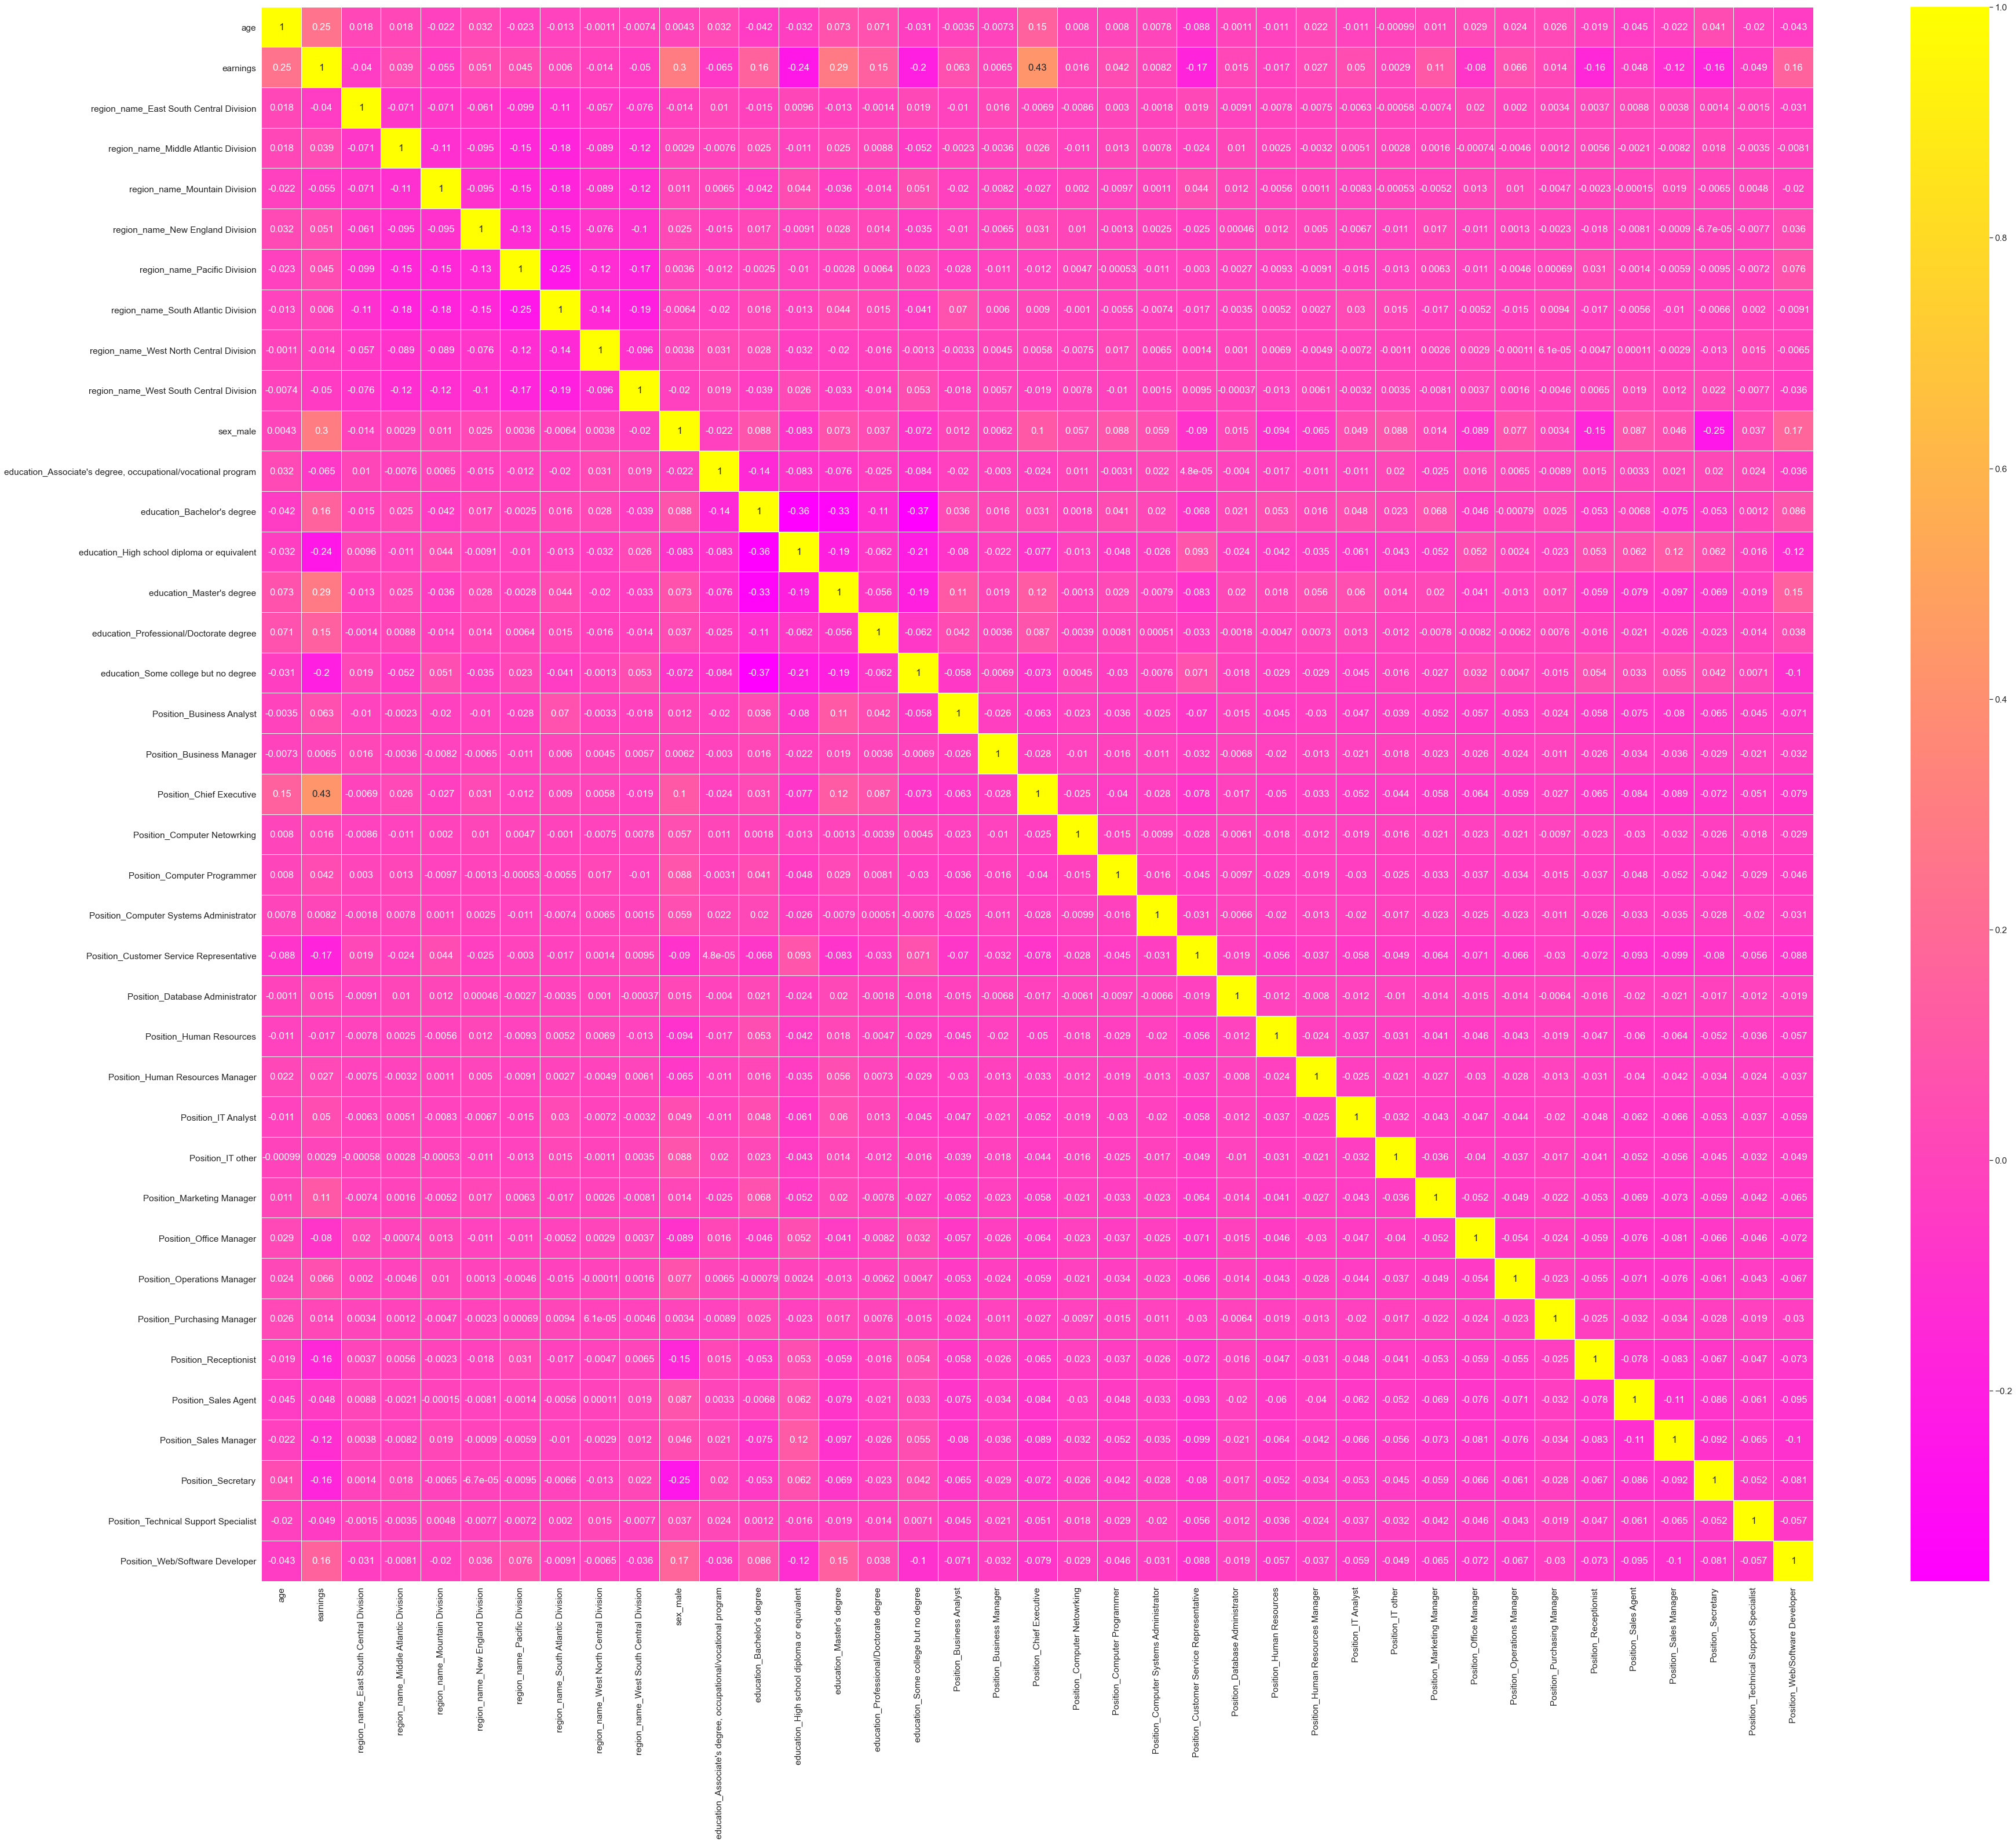

In [24]:
### correlation matrix
sns.set(font_scale = 1.4)
corr = dum_df.corr()
plt.subplots(figsize=(60,50))
sns.heatmap(corr, cmap = 'spring', linewidth =.005, 
            annot = True)
plt.show()

Similar to the ordinal-coded data, the dummy-coded data set is split and the 20% test data is saved to be used only in the final test.

In [25]:
#DUMMY ENCODING 
dum_X = dum_df.drop(["earnings"], axis = 1)
#print(dum_X.info())
dum_y = dum_df.earnings
#print(dum_y)
# Split test and train data
X_train, X_test, y_train, y_test = train_test_split(dum_X, dum_y, test_size = 0.2, random_state = 1)
# Rename final test data so that it doesn't get replaced/used during model training and testing
dum_X_final_test = X_test
dum_y_final_test = y_test
# Rename training data for cross validation testing
dum_X = np.array(X_train)
dum_y = np.array(y_train)

Next, the 10-fold cross validation is initialized for the training of the models.

In [26]:
# Initialize 10-fold cross validation
kf = KFold(n_splits=10)

# Multiple Linear Regression

### Number Encoded Data

With no additional tuning required, the multiple linear regression model is trained and performance results are aggregated over each of the 10 cross validation iterations.

In [27]:
# initialize model
num_MLR = LinearRegression()
# initialize performance metrics
MLR_score = 0
MLR_mse = 0
MLR_mae = 0
MLR_rmse = 0
MLR_explainedvar = 0
###################################### Tuning
# 5-fold cross validation
for train_index, test_index in kf.split(num_X):
    X_train, X_test = num_X[train_index, :], num_X[test_index, :] # split features
    y_train, y_test = num_y[train_index], num_y[test_index] # split target
    num_MLR.fit(X_train, y_train) # fit model
    MLR_ypred = num_MLR.predict(X_test) # make predictions
    MLR_mse += mean_squared_error(y_test, MLR_ypred) # mse
    MLR_score += num_MLR.score(X_test, y_test) # r-squared
    MLR_mae += metrics.mean_absolute_error(y_test, MLR_ypred) # mae
    MLR_rmse += metrics.mean_squared_error(y_test, MLR_ypred, squared = False) # rmse
    MLR_explainedvar += metrics.explained_variance_score(y_test, MLR_ypred) # explained variance
# calculate averate metrics from the 10 fold cv
MLR_score = MLR_score*(1/10)
MLR_mse = MLR_mse*(1/10)
MLR_mae = MLR_mae*(1/10)
MLR_rmse = MLR_rmse*(1/10)
MLR_explainedvar = MLR_explainedvar*(1/10)
# rename to save for table
num_MLR_score = MLR_score
num_MLR_mse = MLR_mse
num_MLR_mae = MLR_mae
num_MLR_rmse = MLR_rmse
num_MLR_explainedvar = MLR_explainedvar

The plot below shows the density distribution of actual (grey) and predicted (pink) earnings values from the cross-validation training.


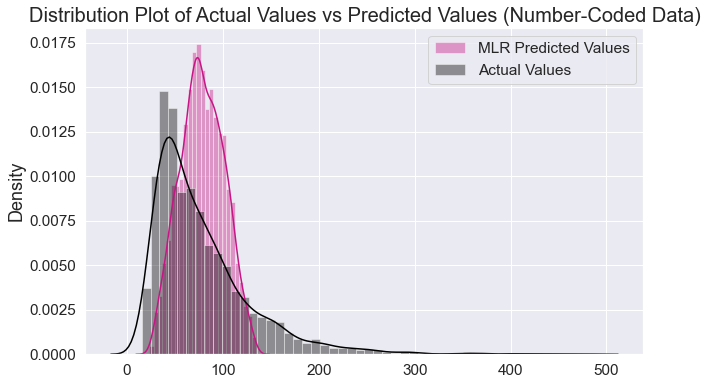

In [28]:
# Predicted VS Actual distribution plot 
plt.figure(figsize=(10,6))
sns.set(font_scale = 1.4)
ax1 = sns.distplot(MLR_ypred, hist = True, color = 'mediumvioletred', label = 'MLR Predicted Values')
ax1 = sns.distplot(y_test, hist = True, color = 'black', label = 'Actual Values')
plt.title('Distribution Plot of Actual Values vs Predicted Values (Number-Coded Data)', size = 20)
plt.ylabel('Density', size = 18)
plt.xlabel('')
plt.legend()
plt.show()

### Dummy Encoded Data

With no additional tuning required, the multiple linear regression model is trained and performance results are aggregated over each of the 10 cross validation iterations.

In [29]:
# initialize model
dum_MLR = LinearRegression()
# Initialize Performance metrics
MLR_score = 0
MLR_mse = 0
MLR_mae = 0
MLR_rmse = 0
MLR_explainedvar = 0
# Start 10-fold cross validation training of model
for train_index, test_index in kf.split(dum_X):
    X_train, X_test = dum_X[train_index, :], dum_X[test_index, :] # split train and test feature data
    y_train, y_test = dum_y[train_index], dum_y[test_index] # split train and test target data
    dum_MLR.fit(X_train, y_train) # fit model
    MLR_ypred = dum_MLR.predict(X_test) # make predictions
    MLR_mse += mean_squared_error(y_test, MLR_ypred) # mse
    MLR_score += dum_MLR.score(X_test, y_test) # r-squared
    MLR_mae += metrics.mean_absolute_error(y_test, MLR_ypred) # mae
    MLR_rmse += metrics.mean_squared_error(y_test, MLR_ypred, squared = False) # rmse
    MLR_explainedvar += metrics.explained_variance_score(y_test, MLR_ypred) # explained variance
# calculate averate metrics from the 10 fold cv
MLR_score = MLR_score*(1/10)
MLR_mse = MLR_mse*(1/10)
MLR_mae = MLR_mae*(1/10)
MLR_rmse = MLR_rmse*(1/10)
MLR_explainedvar = MLR_explainedvar*(1/10)
# rename to save for table
dum_MLR_score = MLR_score
dum_MLR_mse = MLR_mse
dum_MLR_mae = MLR_mae
dum_MLR_rmse = MLR_rmse
dum_MLR_explainedvar = MLR_explainedvar

The plot below shows the density distribution of actual (grey) and predicted (pink) earnings values from the cross-validation training.

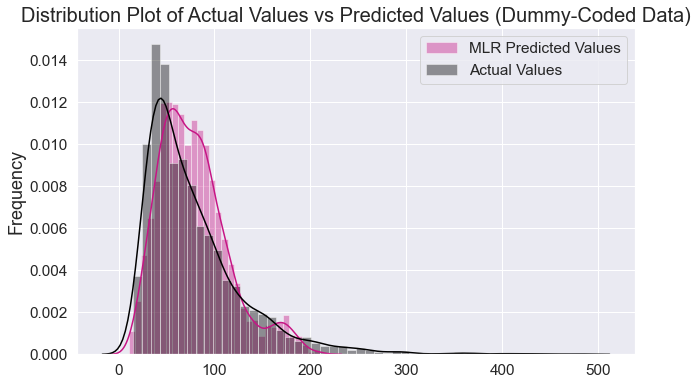

In [30]:
# Predicted VS Actual distribution plot 
plt.figure(figsize=(10,6))
ax1 = sns.distplot(MLR_ypred, hist = True, color = 'mediumvioletred', label = 'MLR Predicted Values')
ax1 = sns.distplot(y_test, hist = True, color = 'black', label = 'Actual Values')
plt.title('Distribution Plot of Actual Values vs Predicted Values (Dummy-Coded Data)', size = 20)
plt.ylabel('Frequency', size = 18)
plt.xlabel('')
plt.legend()
plt.show()

### Results

In [31]:
fig = go.Figure(data=[go.Table(
    header=dict(values=['Trained Model', 'Data Used', 'Average R-Squared', 'Average MSE', 'Average MAE', 'Average RMSE', "Explained Variance"],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[["10-fold CV Multiple Linear Regression", "10-fold CV Multiple Linear Regression"],
                       ["Number", "Dummy", ],
                       [round(num_MLR_score, 2), round(dum_MLR_score,2)],
                       [round(num_MLR_mse, 2), round(dum_MLR_mse,2)],
                       [round(num_MLR_mae,2), round(dum_MLR_mae,2)],
                       [round(num_MLR_rmse,2), round(dum_MLR_rmse,2)],
                       [round(num_MLR_explainedvar,2), round(dum_MLR_explainedvar,2)],
                      ],
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))])
fig.update_layout(width=700, height=600)
fig.show()

The performance results from these two models show that a multiple linear regression model performs better when the dummy-coded data is used compared the the ordinal coded data. 

# Polynomial Regression

### Number Encoded Data

##### Tuning

Tuning of the polynomial regression model using ordinal encoded data includes testing different degree parameter inputs in order to identify the best performing polynomial model with the number-coded data set.

In [32]:
#Split test and train data
X_train, X_test, y_train, y_test = train_test_split(num_X, num_y, test_size = 0.2, random_state = 1)
# initialize results dcit
testerror = {}
# orders that will be tried
num_PR = PolynomialFeatures(2)
X_train, X_test = num_X[train_index, :], num_X[test_index, :] # split features
y_train, y_test = num_y[train_index], num_y[test_index] # split target
X_train_PR = num_PR.fit_transform(X_train) # transform for polynomial regression
X_test_PR = num_PR.fit_transform(X_test) # transform 
num_poly = LinearRegression() # initialize linear model
num_poly.fit(X_train_PR, y_train) #fit with transformed features
PR_ypred = num_poly.predict(X_test_PR) # make predictions
PR_score = num_poly.score(X_test_PR, y_test) # r-squared
PR_mse = mean_squared_error(y_test, PR_ypred) # mse
testerror[2] = (PR_mse, PR_score)
num_PR = PolynomialFeatures(3)
X_train, X_test = num_X[train_index, :], num_X[test_index, :] # split features
y_train, y_test = num_y[train_index], num_y[test_index] # split target
X_train_PR = num_PR.fit_transform(X_train) # transform for polynomial regression
X_test_PR = num_PR.fit_transform(X_test) # transform 
num_poly = LinearRegression() # initialize linear model
num_poly.fit(X_train_PR, y_train) #fit with transformed features
PR_ypred = num_poly.predict(X_test_PR) # make predictions
PR_score = num_poly.score(X_test_PR, y_test) # r-squared
PR_mse = mean_squared_error(y_test, PR_ypred) # mse
testerror[3] = (PR_mse, PR_score)
num_PR = PolynomialFeatures(4)
X_train, X_test = num_X[train_index, :], num_X[test_index, :] # split features
y_train, y_test = num_y[train_index], num_y[test_index] # split target
X_train_PR = num_PR.fit_transform(X_train) # transform for polynomial regression
X_test_PR = num_PR.fit_transform(X_test) # transform 
num_poly = LinearRegression() # initialize linear model
num_poly.fit(X_train_PR, y_train) #fit with transformed features
PR_ypred = num_poly.predict(X_test_PR) # make predictions
PR_score = num_poly.score(X_test_PR, y_test) # r-squared
PR_mse = mean_squared_error(y_test, PR_ypred) # mse
testerror[4] = (PR_mse, PR_score)
num_PR = PolynomialFeatures(5)
X_train, X_test = num_X[train_index, :], num_X[test_index, :] # split features
y_train, y_test = num_y[train_index], num_y[test_index] # split target
X_train_PR = num_PR.fit_transform(X_train) # transform for polynomial regression
X_test_PR = num_PR.fit_transform(X_test) # transform 
num_poly = LinearRegression() # initialize linear model
num_poly.fit(X_train_PR, y_train) #fit with transformed features
PR_ypred = num_poly.predict(X_test_PR) # make predictions
PR_score = num_poly.score(X_test_PR, y_test) # r-squared
PR_mse = mean_squared_error(y_test, PR_ypred) # mse
testerror[5] = (PR_mse, PR_score)
num_PR = PolynomialFeatures(6)
X_train, X_test = num_X[train_index, :], num_X[test_index, :] # split features
y_train, y_test = num_y[train_index], num_y[test_index] # split target
X_train_PR = num_PR.fit_transform(X_train) # transform for polynomial regression
X_test_PR = num_PR.fit_transform(X_test) # transform 
num_poly = LinearRegression() # initialize linear model
num_poly.fit(X_train_PR, y_train) #fit with transformed features
PR_ypred = num_poly.predict(X_test_PR) # make predictions
PR_score = num_poly.score(X_test_PR, y_test) # r-squared
PR_mse = mean_squared_error(y_test, PR_ypred) # mse
testerror[6] = (PR_mse, PR_score)
num_PR = PolynomialFeatures(7)
X_train, X_test = num_X[train_index, :], num_X[test_index, :] # split features
y_train, y_test = num_y[train_index], num_y[test_index] # split target
X_train_PR = num_PR.fit_transform(X_train) # transform for polynomial regression
X_test_PR = num_PR.fit_transform(X_test) # transform 
num_poly = LinearRegression() # initialize linear model
num_poly.fit(X_train_PR, y_train) #fit with transformed features
PR_ypred = num_poly.predict(X_test_PR) # make predictions
PR_score = num_poly.score(X_test_PR, y_test) # r-squared
PR_mse = mean_squared_error(y_test, PR_ypred) # mse
testerror[7] = (PR_mse, PR_score)
# Results table from Tuning
data = [["Polynomial Regression", "number-coded", 2, testerror[2][0], testerror[2][1]],
        ["Polynomial Regression", "number-coded", 3, testerror[3][0], testerror[3][1]],
        ["Polynomial Regression", "number-coded", 4, testerror[4][0], testerror[4][1]],
        ["Polynomial Regression", "number-coded", 5, testerror[5][0], testerror[5][1]],
        ["Polynomial Regression", "number-coded", 6, testerror[6][0], testerror[6][1]],
        ["Polynomial Regression", "number-coded", 7, testerror[7][0], testerror[7][1]]]
print(tabulate(data, headers=["Model", "Data Used", "Degree", "MSE", 
                "R-squared"], tablefmt="fancy_grid"))

╒═══════════════════════╤══════════════╤══════════╤═════════╤═════════════╕
│ Model                 │ Data Used    │   Degree │     MSE │   R-squared │
╞═══════════════════════╪══════════════╪══════════╪═════════╪═════════════╡
│ Polynomial Regression │ number-coded │        2 │ 2077.54 │    0.244909 │
├───────────────────────┼──────────────┼──────────┼─────────┼─────────────┤
│ Polynomial Regression │ number-coded │        3 │ 1988.12 │    0.27741  │
├───────────────────────┼──────────────┼──────────┼─────────┼─────────────┤
│ Polynomial Regression │ number-coded │        4 │ 1874.63 │    0.318659 │
├───────────────────────┼──────────────┼──────────┼─────────┼─────────────┤
│ Polynomial Regression │ number-coded │        5 │ 1716.24 │    0.376225 │
├───────────────────────┼──────────────┼──────────┼─────────┼─────────────┤
│ Polynomial Regression │ number-coded │        6 │ 1629.29 │    0.407828 │
├───────────────────────┼──────────────┼──────────┼─────────┼─────────────┤
│ Polynomial

Based on the results, using a polynomial regression model with the parameter degrees = 7 results in the best performance. It has the lowest MSE and highest R-Squared.

##### Training

Using degrees = 7, this polynomial regression model is trained and performance results are aggregated over each of the 10 cross validation iterations.

In [33]:
# initialize model
num_PR = PolynomialFeatures(7)
# initialize performance metrics
PR_score = 0
PR_mse = 0
PR_mae = 0
PR_rmse = 0
PR_explainedvar = 0
# 10-fold cross validation
for train_index, test_index in kf.split(num_X):
    X_train, X_test = num_X[train_index, :], num_X[test_index, :] # split features
    y_train, y_test = num_y[train_index], num_y[test_index] # split target
    X_train_PR = num_PR.fit_transform(X_train) # transform for polynomial regression
    X_test_PR = num_PR.fit_transform(X_test) # transform 
    num_poly = LinearRegression() # initialize linear model
    num_poly.fit(X_train_PR, y_train) #fit with transformed features
    PR_ypred = num_poly.predict(X_test_PR) # make predictions
    PR_score += num_poly.score(X_test_PR, y_test) # r-squared
    PR_mse += mean_squared_error(y_test, PR_ypred) # mse
    PR_mae += metrics.mean_absolute_error(y_test, PR_ypred) #mae
    PR_rmse += metrics.mean_squared_error(y_test, PR_ypred, squared = False) #rmse
    PR_explainedvar += metrics.explained_variance_score(y_test, PR_ypred) # explained variance
# calculate average metrics from the 10 fold cv     
PR_score = PR_score*(1/10)
PR_mse = PR_mse*(1/10)
PR_mae = PR_mae*(1/10)
PR_rmse = PR_rmse*(1/10)
PR_explainedvar = PR_explainedvar*(1/10)
# rename to save for table
num_PR_score = PR_score
num_PR_mse = PR_mse
num_PR_mae = PR_mae
num_PR_rmse = PR_rmse
num_PR_explainedvar = PR_explainedvar

The plot below shows the density distribution of actual (grey) and predicted (pink) earnings values from the cross-validation training.

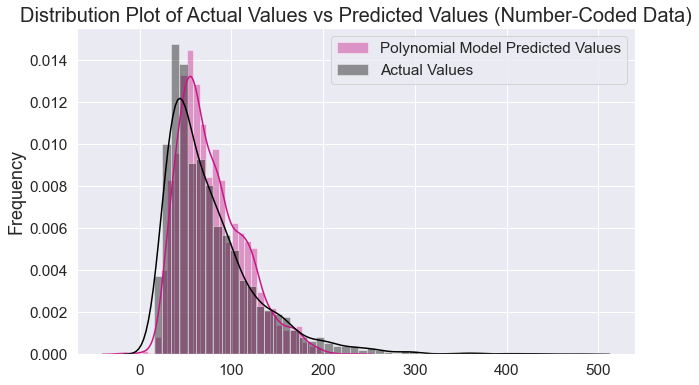

In [34]:
# Predicted VS Actual distribution plot 
plt.figure(figsize=(10,6))
ax1 = sns.distplot(PR_ypred, hist = True, color = 'mediumvioletred', label = 'Polynomial Model Predicted Values')
ax1 = sns.distplot(y_test, hist = True, color = 'black', label = 'Actual Values')
plt.title('Distribution Plot of Actual Values vs Predicted Values (Number-Coded Data)', size = 20)
plt.ylabel('Frequency', size = 18)
plt.xlabel('')
plt.legend()
plt.show()

### Dummy Encoded Data

With no additional tuning, the polynomial regression model is trained and performance results are aggregated over each of the 10 cross validation iterations.

##### Training

In [35]:
# initialize model
dum_PR = PolynomialFeatures(2)
# Initialize Performance metrics
PR_score = 0
PR_mse = 0
PR_mae = 0
PR_rmse = 0
PR_explainedvar = 0
# 10-fold cross validation
for train_index, test_index in kf.split(dum_X):
    X_train, X_test = dum_X[train_index, :], dum_X[test_index, :] # split features
    y_train, y_test = dum_y[train_index], dum_y[test_index] # split target
    X_train_PR = dum_PR.fit_transform(X_train) # transform for polynomial regression
    X_test_PR = dum_PR.fit_transform(X_test) # transform 
    dum_poly = LinearRegression() # initialize linear model
    dum_poly.fit(X_train_PR, y_train) #fit with transformed features
    PR_ypred = dum_poly.predict(X_test_PR) # make predictions
    PR_score += dum_poly.score(X_test_PR, y_test) # r-squared
    PR_mse += mean_squared_error(y_test, PR_ypred) # mse
    PR_mae += metrics.mean_absolute_error(y_test, PR_ypred) #mae
    PR_rmse += metrics.mean_squared_error(y_test, PR_ypred, squared = False) #rmse
    PR_explainedvar += metrics.explained_variance_score(y_test, PR_ypred) # explained variance
# calculate average metrics from the 10 fold cv    
PR_score = PR_score*(1/10)
PR_mse = PR_mse*(1/10)
PR_mae = PR_mae*(1/10)
PR_rmse = PR_rmse*(1/10)
PR_explainedvar = PR_explainedvar*(1/10)
# rename to save for table
dum_PR_score = PR_score
dum_PR_mse = PR_mse
dum_PR_mae = PR_mae
dum_PR_rmse = PR_rmse
dum_PR_explainedvar = PR_explainedvar

The plot below shows the density distribution of actual (grey) and predicted (pink) earnings values from the cross-validation training.

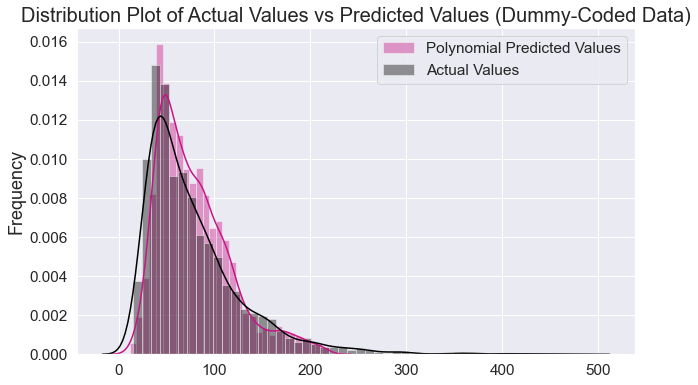

In [36]:
# Predicted VS Actual distribution plot 
plt.figure(figsize=(10,6))
ax1 = sns.distplot(PR_ypred, hist = True, color = 'mediumvioletred', label = 'Polynomial Predicted Values')
ax1 = sns.distplot(y_test, hist = True, color = 'black', label = 'Actual Values')
plt.title('Distribution Plot of Actual Values vs Predicted Values (Dummy-Coded Data)', size = 20)
plt.ylabel('Frequency', size = 18)
plt.xlabel('')
plt.legend()
plt.show()

### Results

In [37]:
fig = go.Figure(data=[go.Table(
    header=dict(values=['Trained Model', 'Data Used', "Degrees", 'Average R-Squared', 'Average MSE', 'Average MAE', 'Average RMSE', "Explained Variance"],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[["10-fold CV Polynomial Regression", "10-fold CV Polynomial Regression"],
                       ["Number", "Dummy", ],
                       ["7", "2"],
                       [round(num_PR_score, 2), round(dum_PR_score,2)],
                       [round(num_PR_mse, 2), round(dum_PR_mse,2)],
                       [round(num_PR_mae,2), round(dum_PR_mae,2)],
                       [round(num_PR_rmse,2), round(dum_PR_rmse,2)],
                       [round(num_PR_explainedvar,2), round(dum_PR_explainedvar,2)],
                      ],
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))])
fig.update_layout(width=800, height=500)
fig.show()

Similar to the MLR models, the Polynomial Regression algorithm performed best when using the dummy coded data. The Mean Squared Error was smaller and the R-squared score was higher when using the dummy coded data.

# K-Neighbors Regressor

### Numeric Encoded Data

Tuning of the K-Neighbors Regressor model includes testing different n_neighbors parameter inputs in order to identify the best performing K-Neighbors Regressor model.

##### Tuning

In [38]:
# find optimal parameter setting for n_neighbors
neighbors = (1,2,3,4,5,6,7,8,9,10,20,30,50,100,200,300)

# Split test and train data
X_train, X_test, y_train, y_test = train_test_split(num_X, num_y, test_size = 0.2, random_state = 1)
# initialize results dictionary
numdict = {}
# for loop to see which parameter results in the best performance
for n in neighbors:
    num_KNN = KNeighborsRegressor(n_neighbors=n) # initialize model
    num_KNN.fit(X_train, y_train) # fit model
    KNN_ypred = num_KNN.predict(X_test) # make predictions
    KNN_score = num_KNN.score(X_test, y_test) #r-squared
    KNN_mse = mean_squared_error(y_test, KNN_ypred) #mse
    numdict[n] = (KNN_mse, KNN_score) # add to results dictionary
# Results table from tuning
data = [["K-Neighbors Regressor", "number-coded", 1, numdict[1][0], numdict[1][1]],
        ["K-Neighbors Regressor", "number-coded", 2, numdict[2][0], numdict[2][1]],
        ["K-Neighbors Regressor", "number-coded", 3, numdict[3][0], numdict[3][1]],
        ["K-Neighbors Regressor", "number-coded", 4, numdict[4][0], numdict[4][1]],
        ["K-Neighbors Regressor", "number-coded", 5, numdict[5][0], numdict[5][1]],
        ["K-Neighbors Regressor", "number-coded", 6, numdict[6][0], numdict[6][1]],
        ["K-Neighbors Regressor", "number-coded", 7, numdict[7][0], numdict[7][1]],
        ["K-Neighbors Regressor", "number-coded", 8, numdict[8][0], numdict[8][1]],
        ["K-Neighbors Regressor", "number-coded", 9, numdict[9][0], numdict[9][1]],
        ["K-Neighbors Regressor", "number-coded", 10, numdict[10][0], numdict[10][1]],
        ["K-Neighbors Regressor", "number-coded", 20, numdict[20][0], numdict[20][1]],
        ["K-Neighbors Regressor", "number-coded", 30, numdict[30][0], numdict[30][1]],
        ["K-Neighbors Regressor", "number-coded", 50, numdict[50][0], numdict[50][1]],
        ["K-Neighbors Regressor", "number-coded", 100, numdict[100][0], numdict[100][1]],
        ["K-Neighbors Regressor", "number-coded", 200, numdict[200][0], numdict[200][1]],
        ["K-Neighbors Regressor", "number-coded", 300, numdict[300][0], numdict[300][1]]]
print(tabulate(data, headers=["Model", "Data Used", "N_Neighbors", "MSE", 
                "R-Squared"], tablefmt="fancy_grid"))

╒═══════════════════════╤══════════════╤═══════════════╤═════════╤═════════════╕
│ Model                 │ Data Used    │   N_Neighbors │     MSE │   R-Squared │
╞═══════════════════════╪══════════════╪═══════════════╪═════════╪═════════════╡
│ K-Neighbors Regressor │ number-coded │             1 │ 2148.91 │    0.223209 │
├───────────────────────┼──────────────┼───────────────┼─────────┼─────────────┤
│ K-Neighbors Regressor │ number-coded │             2 │ 1844.51 │    0.333246 │
├───────────────────────┼──────────────┼───────────────┼─────────┼─────────────┤
│ K-Neighbors Regressor │ number-coded │             3 │ 1725.75 │    0.376174 │
├───────────────────────┼──────────────┼───────────────┼─────────┼─────────────┤
│ K-Neighbors Regressor │ number-coded │             4 │ 1699.73 │    0.385581 │
├───────────────────────┼──────────────┼───────────────┼─────────┼─────────────┤
│ K-Neighbors Regressor │ number-coded │             5 │ 1656.56 │    0.401186 │
├───────────────────────┼───

Based on these results, using a K-Neighbors Regressor model with the parameter n_neighbors = 8 results in the best performance. It has the lowest MSE and highest R-Squared.

##### Training

Using n_neighbors = 8, this K-Neighbors Regressor model is trained and performance results are aggregated over each of the 10 cross validation iterations.

In [39]:
# initialize model
num_KNN = KNeighborsRegressor(n_neighbors=8)
# initialize perofrmance metrics
KNN_score = 0
KNN_mse = 0
KNN_mae = 0
KNN_rmse = 0
KNN_explainedvar = 0
# 5-fold cross validation
for train_index, test_index in kf.split(num_X):
    X_train, X_test = num_X[train_index, :], num_X[test_index, :] # split features
    y_train, y_test = num_y[train_index], num_y[test_index] # split target
    num_KNN.fit(X_train, y_train) # fit model
    KNN_ypred = num_KNN.predict(X_test) # make predictions 
    KNN_score += num_KNN.score(X_test, y_test) # r-squared
    KNN_mse += mean_squared_error(y_test, KNN_ypred) #mse
    KNN_mae += metrics.mean_absolute_error(y_test, KNN_ypred) #mae
    KNN_rmse += metrics.mean_squared_error(y_test, KNN_ypred, squared = False) # rmse
    KNN_explainedvar += metrics.explained_variance_score(y_test, KNN_ypred) #explained variance
# calculate average metrics from the 10 fold cv 
KNN_score = KNN_score*(1/10)
KNN_mse = KNN_mse*(1/10)
KNN_mae = KNN_mae*(1/10)
KNN_rmse = KNN_rmse*(1/10)
KNN_explainedvar = KNN_explainedvar*(1/10)
# rename to save for table
num_KNN_score = KNN_score
num_KNN_mse = KNN_mse
num_KNN_mae = KNN_mae
num_KNN_rmse = KNN_rmse
num_KNN_explainedvar = KNN_explainedvar

The plot below shows the density distribution of actual (grey) and predicted (pink) earnings values from the cross-validation training.

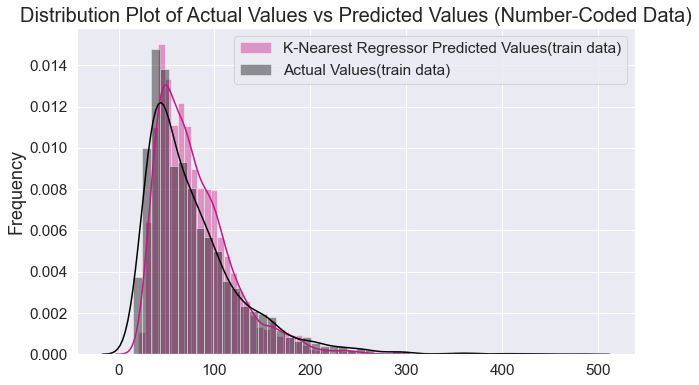

In [40]:
# Predicted VS Actual distribution plot 
plt.figure(figsize=(10,6))
ax1 = sns.distplot(KNN_ypred, hist = True, color = 'mediumvioletred', label = 'K-Nearest Regressor Predicted Values(train data)')
ax1 = sns.distplot(y_test, hist = True, color = 'black', label = 'Actual Values(train data)')
plt.title('Distribution Plot of Actual Values vs Predicted Values (Number-Coded Data)', size = 20)
plt.ylabel('Frequency', size = 18)
plt.xlabel('')
plt.legend()
plt.show()

### Dummy Encoded Data

##### Tuning

Using different n_neighbors parameter inputs in order to identify the best performing K-Neighbors Regressor model.

In [41]:
# Split test and train data
X_train, X_test, y_train, y_test = train_test_split(dum_X, dum_y, test_size = 0.2, random_state = 1)
###################################### Tuning
# find optimal parameter setting for n_neighbors
neighbors = (1,2,3,4,5,6,7,8,9,10,20,30,50,100,200,300)
# initialize results dictionary
numdict = {}
# Use for loop to see what parameter results in best performance
for n in neighbors:
    dum_KNN = KNeighborsRegressor(n_neighbors=n) # initialize model
    dum_KNN.fit(X_train, y_train) # fit model
    KNN_ypred = dum_KNN.predict(X_test) # make predictions 
    KNN_score = dum_KNN.score(X_test, y_test)#r-squared
    KNN_mse = mean_squared_error(y_test, KNN_ypred)#mse
    numdict[n] = (KNN_mse, KNN_score) # add to results dictionary
# Results table from tuning
data = [["K-Neighbors Regressor", "dummy-coded", 1, numdict[1][0], numdict[1][1]],
        ["K-Neighbors Regressor", "dummy-coded", 2, numdict[2][0], numdict[2][1]],
        ["K-Neighbors Regressor", "dummy-coded", 3, numdict[3][0], numdict[3][1]],
        ["K-Neighbors Regressor", "dummy-coded", 4, numdict[4][0], numdict[4][1]],
        ["K-Neighbors Regressor", "dummy-coded", 5, numdict[5][0], numdict[5][1]],
        ["K-Neighbors Regressor", "dummy-coded", 6, numdict[6][0], numdict[6][1]],
        ["K-Neighbors Regressor", "dummy-coded", 7, numdict[7][0], numdict[7][1]],
        ["K-Neighbors Regressor", "dummy-coded", 8, numdict[8][0], numdict[8][1]],
        ["K-Neighbors Regressor", "dummy-coded", 9, numdict[9][0], numdict[9][1]],
        ["K-Neighbors Regressor", "dummy-coded", 10, numdict[10][0], numdict[10][1]],
        ["K-Neighbors Regressor", "dummy-coded", 20, numdict[20][0], numdict[20][1]],
        ["K-Neighbors Regressor", "dummy-coded", 30, numdict[30][0], numdict[30][1]],
        ["K-Neighbors Regressor", "dummy-coded", 50, numdict[50][0], numdict[50][1]],
        ["K-Neighbors Regressor", "dummy-coded", 100, numdict[100][0], numdict[100][1]],
        ["K-Neighbors Regressor", "dummy-coded", 200, numdict[200][0], numdict[200][1]],
        ["K-Neighbors Regressor", "dummy-coded", 300, numdict[300][0], numdict[300][1]]]
print(tabulate(data, headers=["Model", "Data Used", "N_Neighbors", "MSE", 
                "R-Squared"], tablefmt="fancy_grid"))

╒═══════════════════════╤═════════════╤═══════════════╤═════════╤═════════════╕
│ Model                 │ Data Used   │   N_Neighbors │     MSE │   R-Squared │
╞═══════════════════════╪═════════════╪═══════════════╪═════════╪═════════════╡
│ K-Neighbors Regressor │ dummy-coded │             1 │ 2032.78 │    0.265189 │
├───────────────────────┼─────────────┼───────────────┼─────────┼─────────────┤
│ K-Neighbors Regressor │ dummy-coded │             2 │ 1676.17 │    0.394096 │
├───────────────────────┼─────────────┼───────────────┼─────────┼─────────────┤
│ K-Neighbors Regressor │ dummy-coded │             3 │ 1603.08 │    0.420518 │
├───────────────────────┼─────────────┼───────────────┼─────────┼─────────────┤
│ K-Neighbors Regressor │ dummy-coded │             4 │ 1576.59 │    0.430091 │
├───────────────────────┼─────────────┼───────────────┼─────────┼─────────────┤
│ K-Neighbors Regressor │ dummy-coded │             5 │ 1544.86 │    0.441564 │
├───────────────────────┼─────────────┼─

Based on these results, using a K-Neighbors Regressor model with the parameter n_neighbors = 10 results in the best performance. It has the lowest MSE and highest R-Squared.

##### Training

Using n_neighbors = 10, this K-Neighbors Regressor model is trained and performance results are aggregated over each of the 10 cross validation iterations.

In [42]:
# initialize model
dum_KNN = KNeighborsRegressor(n_neighbors=10)
# Initialize perofrmance metrics
KNN_score = 0
KNN_mse = 0
KNN_mae = 0
KNN_rmse = 0
KNN_explainedvar = 0
# 5-fold cross validation
for train_index, test_index in kf.split(dum_X):
    X_train, X_test = dum_X[train_index, :], dum_X[test_index, :] # Split feature data
    y_train, y_test = dum_y[train_index], dum_y[test_index] # split target data
    dum_KNN.fit(X_train, y_train) # fit model
    KNN_ypred = dum_KNN.predict(X_test) # make predictions
    KNN_score += dum_KNN.score(X_test, y_test) # r-squared
    KNN_mse += mean_squared_error(y_test, KNN_ypred) # mse
    KNN_mae += metrics.mean_absolute_error(y_test, KNN_ypred) # mae
    KNN_rmse += metrics.mean_squared_error(y_test, KNN_ypred, squared = False) # rmse
    KNN_explainedvar += metrics.explained_variance_score(y_test, KNN_ypred) # explained variance
# calculate average metrics from the 10 fold cv  
KNN_score = KNN_score*(1/10)
KNN_mse = KNN_mse*(1/10)
KNN_mae = KNN_mae*(1/10)
KNN_rmse = KNN_rmse*(1/10)
KNN_explainedvar = KNN_explainedvar*(1/10)
# rename to save for table
dum_KNN_score = KNN_score
dum_KNN_mse = KNN_mse
dum_KNN_mae = KNN_mae
dum_KNN_rmse = KNN_rmse
dum_KNN_explainedvar = KNN_explainedvar

The plot below shows the density distribution of actual (grey) and predicted (pink) earnings values from the cross-validation training.

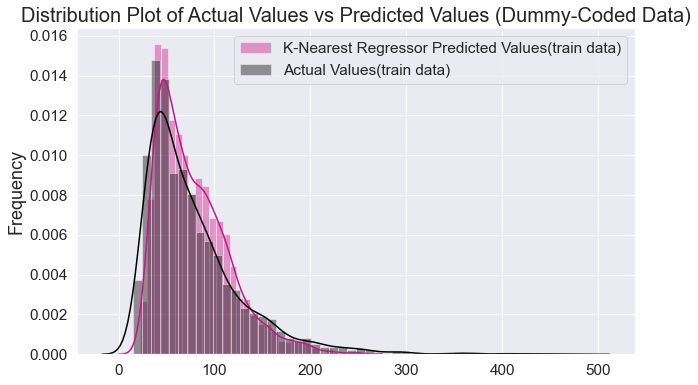

In [43]:
# Predicted VS Actual distribution plot 
plt.figure(figsize=(10,6))
ax1 = sns.distplot(KNN_ypred, hist = True, color = 'mediumvioletred', label = 'K-Nearest Regressor Predicted Values(train data)')
ax1 = sns.distplot(y_test, hist = True, color = 'black', label = 'Actual Values(train data)')
plt.title('Distribution Plot of Actual Values vs Predicted Values (Dummy-Coded Data)', size = 20)
plt.ylabel('Frequency', size = 18)
plt.xlabel('')
plt.legend()
plt.show()

### Results

In [44]:
fig = go.Figure(data=[go.Table(
    header=dict(values=['Trained Model', 'Data Used', "neighbors",'Average R-Squared', 'Average MSE', 'Average MAE', 'Average RMSE', "Explained Variance"],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[["10-fold CV K-Neighbor Regressor", "10-fold CV K-Neighbor Regressor"],
                       ["Number", "Dummy", ],
                       ["8", "10"],
                       [round(num_KNN_score, 2), round(dum_KNN_score,2)],
                       [round(num_KNN_mse, 2), round(dum_KNN_mse,2)],
                       [round(num_KNN_mae,2), round(dum_KNN_mae,2)],
                       [round(num_KNN_rmse,2), round(dum_KNN_rmse,2)],
                       [round(num_KNN_explainedvar,2), round(dum_KNN_explainedvar,2)],
                      ],
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))])
fig.update_layout(width=800, height=500)
fig.show()

Again, the dummy coded data resulted in better performance from the K-Neighbors Regressor model.

# Random Forest Regressor

### Number Encoded Data

##### Tuning

Tuning of the Random Forest Regressor model includes testing different n_estimator parameter inputs in order to identify the best performing K-Neighbors Regressor model.

In [45]:
# find optimal parameter setting for n_estimators
X_train, X_test, y_train, y_test = train_test_split(num_X, num_y, test_size = 0.20, random_state = 1)
###################################### Tuning
estimators = [10, 50, 100, 150, 200, 250, 300]
# initialize results dictionary
estdict = {}
# Use for loop to see what parameter results in best performance
for estimator in estimators:
    num_RF = RandomForestRegressor(n_estimators = estimator, random_state = 1)
    num_RF.fit(X_train, y_train)
    RF_ypred = num_RF.predict(X_test)
    RF_mse = mean_squared_error(y_test, RF_ypred)
    RF_score = num_RF.score(X_test, y_test)
    estdict[estimator] = (RF_mse, RF_score)
# Results table from tuning
from tabulate import tabulate  
data = [["Random Forest Regression", "number-coded", 10, estdict[10][0], estdict[10][1]],
        ["Random Forest Regression", "number-coded", 50,  estdict[50][0], estdict[50][1]],
        ["Random Forest Regression", "number-coded", 100,  estdict[100][0], estdict[100][1]],
        ["Random Forest Regression", "number-coded", 150,  estdict[150][0], estdict[150][1]],
        ["Random Forest Regression", "number-coded", 200,  estdict[200][0], estdict[200][1]],
        ["Random Forest Regression", "number-coded", 250,  estdict[250][0], estdict[250][1]],
        ["Random Forest Regression", "number-coded", 300,  estdict[300][0], estdict[300][1]]]
print(tabulate(data, headers=["Model", "Data Used", "N_Estimators", "MSE", 
                "R-Squared"], tablefmt="fancy_grid"))

╒══════════════════════════╤══════════════╤════════════════╤═════════╤═════════════╕
│ Model                    │ Data Used    │   N_Estimators │     MSE │   R-Squared │
╞══════════════════════════╪══════════════╪════════════════╪═════════╪═════════════╡
│ Random Forest Regression │ number-coded │             10 │ 1536.16 │    0.444707 │
├──────────────────────────┼──────────────┼────────────────┼─────────┼─────────────┤
│ Random Forest Regression │ number-coded │             50 │ 1427.48 │    0.483995 │
├──────────────────────────┼──────────────┼────────────────┼─────────┼─────────────┤
│ Random Forest Regression │ number-coded │            100 │ 1412.69 │    0.48934  │
├──────────────────────────┼──────────────┼────────────────┼─────────┼─────────────┤
│ Random Forest Regression │ number-coded │            150 │ 1405.25 │    0.492031 │
├──────────────────────────┼──────────────┼────────────────┼─────────┼─────────────┤
│ Random Forest Regression │ number-coded │            200 │ 1401

Based on these results, using a Random Forest Regressor model with the parameter n_estimator = 250 results in the best performance. It has the lowest MSE and highest R-Squared.
##### Training
Using n_estimator = 250, this Random Forest Regressor model is trained and performance results are aggregated over each of the 10 cross validation iterations.

In [46]:
num_RF = RandomForestRegressor(n_estimators = 250, random_state = 1)
# Initialize perofrmance metrics
RF_score = 0
RF_mse = 0
RF_mae = 0
RF_rmse = 0
RF_explainedvar = 0
# 5-fold cross validation
for train_index, test_index in kf.split(num_X):
    X_train, X_test = num_X[train_index, :], num_X[test_index, :] # split feature data
    y_train, y_test = num_y[train_index], num_y[test_index] # split target data
    num_RF.fit(X_train, y_train) # fit model
    RF_ypred = num_RF.predict(X_test) # make predictions
    RF_score += num_RF.score(X_test, y_test) # r-squared score
    RF_mse += mean_squared_error(y_test, RF_ypred) # mse
    RF_mae += metrics.mean_absolute_error(y_test, RF_ypred) # mae
    RF_rmse += metrics.mean_squared_error(y_test, RF_ypred, squared = False) # rmse
    RF_explainedvar += metrics.explained_variance_score(y_test, RF_ypred) # explained variance
# calculate average metrics from the 10 fold cv  
RF_score = RF_score*(1/10)
RF_mse = RF_mse*(1/10)
RF_mae = RF_mae*(1/10)
RF_rmse = RF_rmse*(1/10)
RF_explainedvar = RF_explainedvar*(1/10)
# rename to save for table
num_RF_score = RF_score
num_RF_mse = RF_mse
num_RF_mae = RF_mae
num_RF_rmse = RF_rmse
num_RF_explainedvar = RF_explainedvar

The plot below shows the density distribution of actual (grey) and predicted (pink) earnings values from the cross-validation training.

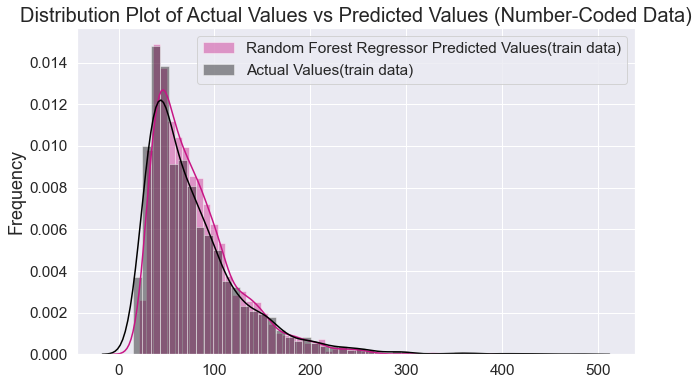

In [47]:
# Predicted VS Actual distribution plot
plt.figure(figsize=(10,6))
ax1 = sns.distplot(RF_ypred, hist = True, color = 'mediumvioletred', label = 'Random Forest Regressor Predicted Values(train data)')
ax1 = sns.distplot(y_test, hist = True, color = 'black', label = 'Actual Values(train data)')
plt.title('Distribution Plot of Actual Values vs Predicted Values (Number-Coded Data)', size = 20)
plt.ylabel('Frequency', size = 18)
plt.xlabel('')
plt.legend()
plt.show()

### Dummy Encoded Data
##### Tuning
Testing different n_estimator parameter inputs in order to identify the best performing Random Forest Regressor model.

In [48]:
# find optimal parameter setting for n_estimators
X_train, X_test, y_train, y_test = train_test_split(dum_X, dum_y, test_size = 0.20, random_state = 1)
###################################### Tuning
estimators = [10, 50, 100, 150, 200, 250, 300]
# initialize results dictionary
estdict = {}
# Use for loop to see what parameter results in best performance
for estimator in estimators:
    dum_RF = RandomForestRegressor(n_estimators = estimator, random_state = 1)
    dum_RF.fit(X_train, y_train)
    RF_ypred = dum_RF.predict(X_test)
    RF_mse = mean_squared_error(y_test, RF_ypred)
    RF_score = dum_RF.score(X_test, y_test)
    estdict[estimator] = (RF_mse, RF_score)
# Results table from tuning
from tabulate import tabulate  
data = [["Random Forest Regression", "dummy-coded", 10, estdict[10][0], estdict[10][1]],
        ["Random Forest Regression", "dummy-coded", 50,  estdict[50][0], estdict[50][1]],
        ["Random Forest Regression", "dummy-coded", 100,  estdict[100][0], estdict[100][1]],
        ["Random Forest Regression", "dummy-coded", 150,  estdict[150][0], estdict[150][1]],
        ["Random Forest Regression", "dummy-coded", 200,  estdict[200][0], estdict[200][1]],
        ["Random Forest Regression", "dummy-coded", 250,  estdict[250][0], estdict[250][1]],
        ["Random Forest Regression", "dummy-coded", 300,  estdict[300][0], estdict[300][1]]]
print(tabulate(data, headers=["Model", "Data Used", "N_Estimators", "MSE", 
                "R-Squared"], tablefmt="fancy_grid"))

╒══════════════════════════╤═════════════╤════════════════╤═════════╤═════════════╕
│ Model                    │ Data Used   │   N_Estimators │     MSE │   R-Squared │
╞══════════════════════════╪═════════════╪════════════════╪═════════╪═════════════╡
│ Random Forest Regression │ dummy-coded │             10 │ 1509.9  │    0.454201 │
├──────────────────────────┼─────────────┼────────────────┼─────────┼─────────────┤
│ Random Forest Regression │ dummy-coded │             50 │ 1412.98 │    0.489234 │
├──────────────────────────┼─────────────┼────────────────┼─────────┼─────────────┤
│ Random Forest Regression │ dummy-coded │            100 │ 1405.41 │    0.491972 │
├──────────────────────────┼─────────────┼────────────────┼─────────┼─────────────┤
│ Random Forest Regression │ dummy-coded │            150 │ 1395.39 │    0.495592 │
├──────────────────────────┼─────────────┼────────────────┼─────────┼─────────────┤
│ Random Forest Regression │ dummy-coded │            200 │ 1392.74 │    0.4

Based on these results, using a Random Forest Regressor model with the parameter n_estimator = 250 results in the best performance. It has the lowest MSE and highest R-Squared.
##### Training
Using n_estimator = 250, this Random Forest Regressor model is trained and performance results are aggregated over each of the 10 cross validation iterations.

In [49]:
dum_RF = RandomForestRegressor(n_estimators = 250, random_state = 1)
# Initialize perofrmance metrics
RF_score = 0
RF_mse = 0
RF_mae = 0
RF_rmse = 0
RF_explainedvar = 0
# 5-fold cross validation
for train_index, test_index in kf.split(dum_X):
    X_train, X_test = dum_X[train_index, :], dum_X[test_index, :] # split feature data
    y_train, y_test = dum_y[train_index], dum_y[test_index] # split target data
    dum_RF.fit(X_train, y_train) # fit model
    RF_ypred = dum_RF.predict(X_test) # make predictions
    RF_score += dum_RF.score(X_test, y_test) # r-squared score
    RF_mse += mean_squared_error(y_test, RF_ypred) # mse
    RF_mae += metrics.mean_absolute_error(y_test, RF_ypred) # mae
    RF_rmse += metrics.mean_squared_error(y_test, RF_ypred, squared = False) # rmse
    RF_explainedvar += metrics.explained_variance_score(y_test, RF_ypred) # explained variance
# calculate average metrics from the 10 fold cv  
RF_score = RF_score*(1/10)
RF_mse = RF_mse*(1/10)
RF_mae = RF_mae*(1/10)
RF_rmse = RF_rmse*(1/10)
RF_explainedvar = RF_explainedvar*(1/10)
#rename
dum_RF_score = RF_score
dum_RF_mse = RF_mse
dum_RF_mae = RF_mae
dum_RF_rmse = RF_rmse
dum_RF_explainedvar = RF_explainedvar

The plot below shows the density distribution of actual (grey) and predicted (pink) earnings values from the cross-validation training.

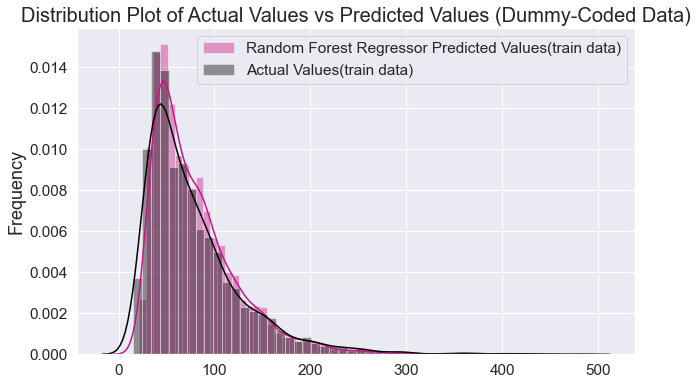

In [50]:
# Predicted VS Actual distribution plot
plt.figure(figsize=(10,6))
ax1 = sns.distplot(RF_ypred, hist = True, color = 'mediumvioletred', label = 'Random Forest Regressor Predicted Values(train data)')
ax1 = sns.distplot(y_test, hist = True, color = 'black', label = 'Actual Values(train data)')
plt.title('Distribution Plot of Actual Values vs Predicted Values (Dummy-Coded Data)', size = 20)
plt.ylabel('Frequency', size = 18)
plt.xlabel('')
plt.legend()
plt.show()

### Results

In [51]:
fig = go.Figure(data=[go.Table(
    header=dict(values=['Trained Model', 'Data Used','Average R-Squared', 'Average MSE', 'Average MAE', 'Average RMSE', "Explained Variance"],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[["10-fold CV Random Forest Regressor", "10-fold CV Random Forest Regressor"],
                       ["Dummy", "Dummy", ],
                       [round(num_RF_score, 2), round(dum_RF_score,2)],
                       [round(num_RF_mse, 2), round(dum_RF_mse,2)],
                       [round(num_RF_mae,2), round(dum_RF_mae,2)],
                       [round(num_RF_rmse,2), round(dum_RF_rmse,2)],
                       [round(num_RF_explainedvar,2), round(dum_RF_explainedvar,2)],
                      ],
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))])
fig.update_layout(width=800, height=500)
fig.show()

The dummy coded data resulted in better performance from the Random Forest Regressor model.

# Ridge & Lasso Regression

### Generate Dummy Coded Data (all features)

In [52]:
# get dummies
dummies = pd.get_dummies(df[['region_name','sex', 'education', 'Position']], drop_first=(True))
# create target data set
y = df.earnings
# drop categorical features from feature data
X_ = df.drop(['region_name','sex', 'education', 'Position', 'earnings'], axis = 1).astype('float64')
# create feature data set
X = pd.concat([X_, dummies], axis = 1)
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# Rename final test data so that it doesn't get replaced/used during model training and testing
ridge_dum_X_final_test = X_test
ridge_dum_y_final_test = y_test
# convert training data to numpy array and rename it for cross validation training
X = np.array(X_train)
y = np.array(y_train)
# re-split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

## Ridge Regression

In [53]:
# generate alphas
alphas = 10**np.linspace(10,-2,100)*0.5
# initialize cross validation
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
# fit 
ridgecv.fit(X_train, y_train)
# generate alphas
ridgecv.alpha_
# initialize Ridge model
ridge = Ridge(alpha = ridgecv.alpha_, normalize = True)
# fit Ridge model
ridge.fit(X_train, y_train)
# make predictions
ridge_ypred = ridge.predict(X_test)
ridge_score = r2_score(y_test, ridge_ypred) # r-squared
ridge_mse = mean_squared_error(y_test, ridge_ypred) #mse
ridge_mae = mean_absolute_error(y_test, ridge_ypred) #mae
ridge_rmse = mean_squared_error(y_test, ridge_ypred, squared = False) # rmse
ridge_explainedvar= explained_variance_score(y_test, ridge_ypred) # explained variance

The plot below shows the density distribution of actual (grey) and predicted (pink) earnings values from the cross-validation training.

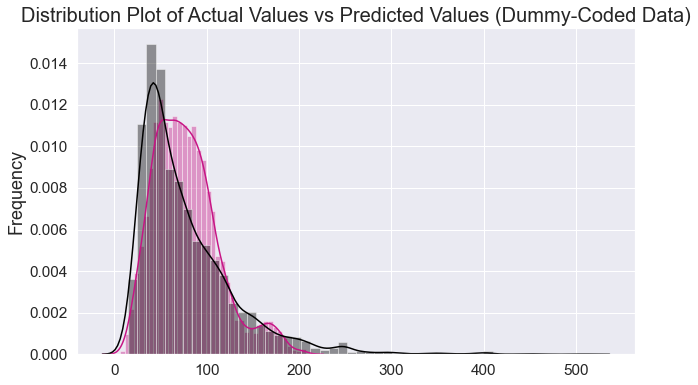

In [54]:
# Predicted VS Actual distribution plot
plt.figure(figsize=(10,6))
ax1 = sns.distplot(ridge_ypred, hist = True, color = 'mediumvioletred', label = 'Ridge Regression Predicted Values(train data)')
ax1 = sns.distplot(y_test, hist = True, color = 'black', label = 'Actual Values(train data)')
plt.title('Distribution Plot of Actual Values vs Predicted Values (Dummy-Coded Data)', size = 20)
plt.ylabel('Frequency', size = 18)
plt.xlabel('')
plt.show()

## Lasso Regression

In [55]:
# intitialize Lasso model
lasso = Lasso(max_iter = 10000, normalize = True)
# initialize lasso cross validation
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
# fit cross validation model
lassocv.fit(X_train, y_train)
# set parameters for lasso model
lasso.set_params(alpha=lassocv.alpha_)
# fit lasso model
lasso.fit(X_train, y_train)
# make predictions
lasso_ypred = lasso.predict(X_test)
lasso_score = r2_score(y_test, lasso_ypred) # r-squared
lasso_mse = mean_squared_error(y_test, lasso_ypred) #mse
lasso_mae = mean_absolute_error(y_test, lasso_ypred) #mae
lasso_rmse = mean_squared_error(y_test, lasso_ypred, squared = False) #rmse
lasso_explainedvar= explained_variance_score(y_test, lasso_ypred) # explained variance

The plot below shows the density distribution of actual (grey) and predicted (pink) earnings values from the cross-validation training.

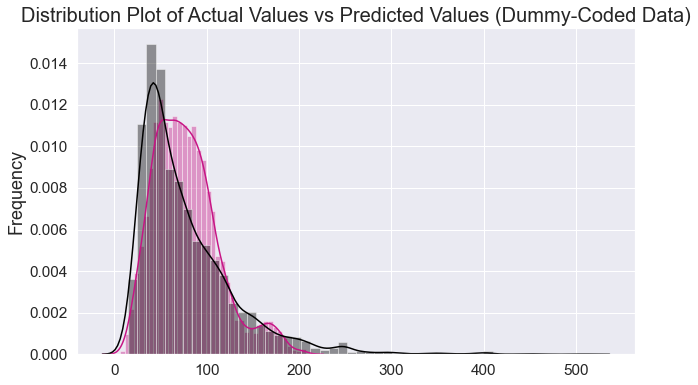

In [56]:
# Predicted VS Actual distribution plot
plt.figure(figsize=(10,6))
ax1 = sns.distplot(ridge_ypred, hist = True, color = 'mediumvioletred', label = 'Lasso Regression Predicted Values(train data)')
ax1 = sns.distplot(y_test, hist = True, color = 'black', label = 'Actual Values(train data)')
plt.title('Distribution Plot of Actual Values vs Predicted Values (Dummy-Coded Data)', size = 20)
plt.ylabel('Frequency', size = 18)
plt.xlabel('')
plt.show()

### Results

In [57]:
fig = go.Figure(data=[go.Table(
    header=dict(values=['Trained Model', 'Data Used','Average R-Squared', 'Average MSE', 'Average MAE', 'Average RMSE', "Explained Variance"],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[["10-fold CV Ridge Regression", "10-fold CV Lasso Regression"],
                       ["Number", "Dummy", ],
                       [round(ridge_score, 2), round(lasso_score,2)],
                       [round(ridge_mse, 2), round(lasso_mse,2)],
                       [round(ridge_mae,2), round(lasso_mae,2)],
                       [round(ridge_rmse,2), round(lasso_rmse,2)],
                       [round(ridge_explainedvar,2), round(lasso_explainedvar,2)],
                      ],
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))])

fig.update_layout(width=800, height=500)
fig.show()

# TRAINING RESULTS

In [58]:
fig = go.Figure(data=[go.Table(
    header=dict(values=['Trained Model', 'Data Used', 'Parameter', 'Average R-Squared', 'Average MSE', 'Average MAE', 'Average RMSE', "Explained Variance"],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[["10-fold CV Multiple Linear Regression", "10-fold CV Multiple Linear Regression", "10-fold CV Polynomial Regression", "10-fold CV Polynomial Regression", "10-fold CV K-Neighbor Regressor","10-fold CV K-Neighbor Regressor","10-fold CV Random Forest Regressor", "10-fold CV Random Forest Regressor","10-fold CV Ridge Regresson", "10-fold CV Lasso Regresson"],
                       ["Number", "Dummy", "Number", "Dummy", "Number", "Dummy", "Number", "Dummy", "Dummy", "Dummy"],
                       ['None', 'None','Degree = 7', 'Degree = 2', 'N_neighbors = 8', 'N_neighbors = 10', 'N_estimators = 250', 'N_estimators = 250', 'None', 'None' ],
                       [round(num_MLR_score,2), round(dum_MLR_score,2), round(num_PR_score,2), round(dum_PR_score,2), round(num_KNN_score,2), round(dum_KNN_score,2), round(num_RF_score,2), round(dum_RF_score,2), round(ridge_score,2), round(lasso_score,2)],
                       [round(num_MLR_mse,2), round(dum_MLR_mse,2), round(num_PR_mse,2), round(dum_PR_mse,2), round(num_KNN_mse,2), round(dum_KNN_mse,2), round(num_RF_mse,2), round(dum_RF_mse,2), round(ridge_mse,2), round(lasso_mse,2)],
                       [round(num_MLR_mae,2), round(dum_MLR_mae,2), round(num_PR_mae,2), round(dum_PR_mae,2), round(num_KNN_mae,2), round(dum_KNN_mae,2), round(num_RF_mae,2), round(dum_RF_mae,2), round(ridge_mae,2), round(lasso_mae,2)],
                       [round(num_MLR_rmse,2), round(dum_MLR_rmse,2), round(num_PR_rmse,2), round(dum_PR_rmse,2), round(num_KNN_rmse,2), round(dum_KNN_rmse,2), round(num_RF_rmse,2), round(dum_RF_rmse,2), round(ridge_rmse,2), round(lasso_rmse,2)],
                       [round(num_MLR_explainedvar,2), round(dum_MLR_explainedvar,2), round(num_PR_explainedvar,2), round(dum_PR_explainedvar,2), round(num_KNN_explainedvar,2), round(dum_KNN_explainedvar,2), round(num_RF_explainedvar,2), round(dum_RF_explainedvar,2), round(ridge_explainedvar,2), round(lasso_explainedvar,2)],
                      ],
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))])

fig.update_layout(width=1400, height=800)
fig.show()

# Final Test

It's now time where we will test each algorithm's ability to predict job salaries for a set of test data that it has not been trained with. To recap, the following are the top-performing models I have identified: 
- Multiple Linear Regression (dummy coded data)
- Polynomial Regression (dummy coded data)
- K-Nearest Neighbor with n_neighbors = 30 (number coded data)
- Random Forest Regressor with n_esitmators = 300 (dummy coded data)
- Ridge Regression
- Lasso Regression

In [59]:
# Final Test Data 
dum_X_final_test 
dum_y_final_test 

ridge_dum_X_final_test
ridge_dum_y_final_test

# Multipule Linear Regression
MLR_ypred = dum_MLR.predict(dum_X_final_test)
# MLR Performance
MLR_score = metrics.r2_score(dum_y_final_test, MLR_ypred)
MLR_mse = metrics.mean_squared_error(dum_y_final_test, MLR_ypred)
MLR_mae = metrics.mean_absolute_error(dum_y_final_test, MLR_ypred)
MLR_rmse = metrics.mean_squared_error(dum_y_final_test, MLR_ypred, squared = False)
MLR_explainedvar = metrics.explained_variance_score(dum_y_final_test, MLR_ypred)


# Polynomial Prediction
X_test_PR = dum_PR.fit_transform(dum_X_final_test)
PR_ypred = dum_poly.predict(X_test_PR)
# Polynomial Performance Metrics
PR_r_squared = metrics.r2_score(dum_y_final_test, PR_ypred)
PR_mae = metrics.mean_absolute_error(dum_y_final_test, PR_ypred)
PR_mse = metrics.mean_squared_error(dum_y_final_test, PR_ypred)
PR_rmse = metrics.mean_squared_error(dum_y_final_test, PR_ypred, squared = False)
PR_explainedvar = metrics.explained_variance_score(dum_y_final_test, PR_ypred)

# KNN Prediction
KNN_ypred = dum_KNN.predict(dum_X_final_test)
# KNN Performance Metrics
KNN_r_squared = metrics.r2_score(dum_y_final_test, KNN_ypred)
KNN_mae = metrics.mean_absolute_error(dum_y_final_test, KNN_ypred)
KNN_mse = metrics.mean_squared_error(dum_y_final_test, KNN_ypred)
KNN_rmse = metrics.mean_squared_error(dum_y_final_test, KNN_ypred, squared = False)
KNN_explainedvar = metrics.explained_variance_score(dum_y_final_test, KNN_ypred)

# Random Forest Prediction
RF_ypred = num_RF.predict(num_X_final_test)
# Random Forest Performance Metrics
RF_r_squared = metrics.r2_score(num_y_final_test, RF_ypred)
RF_mae = metrics.mean_absolute_error(num_y_final_test, RF_ypred)
RF_mse = metrics.mean_squared_error(num_y_final_test, RF_ypred)
RF_rmse = metrics.mean_squared_error(num_y_final_test, RF_ypred, squared = False)
RF_explainedvar = metrics.explained_variance_score(num_y_final_test, RF_ypred)

# Ridge Prediction
ridge_ypred = ridge.predict(ridge_dum_X_final_test)
# Ridge Performance Metrics
ridge_score = r2_score(ridge_dum_y_final_test, ridge_ypred) 
ridge_mse = mean_squared_error(ridge_dum_y_final_test, ridge_ypred) 
ridge_mae = mean_absolute_error(ridge_dum_y_final_test, ridge_ypred)
ridge_rmse = mean_squared_error(ridge_dum_y_final_test, ridge_ypred, squared = False) 
ridge_explainedvar= explained_variance_score(ridge_dum_y_final_test, ridge_ypred) 

# Lasso Prediction
lasso_ypred = lasso.predict(ridge_dum_X_final_test)
# Lasso Performance Metrics
lasso_score = r2_score(ridge_dum_y_final_test, lasso_ypred) 
lasso_mse = mean_squared_error(ridge_dum_y_final_test, lasso_ypred) 
lasso_mae = mean_absolute_error(ridge_dum_y_final_test, lasso_ypred) 
lasso_rmse = mean_squared_error(ridge_dum_y_final_test, lasso_ypred, squared = False) 
lasso_explainedvar= explained_variance_score(ridge_dum_y_final_test, lasso_ypred) 


# Results

In [60]:
fig = go.Figure(data=[go.Table(
    header=dict(values=["ML Model", "R-Squared", "MSE", "MAE", "RMSE", "Explained Variance"],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[["Multiple Linear Regression", "Polynomial Regression", "K-Neighbor Regressor","Random Forest Regressor", "Ridge Regresson", "Lasso Regresson"],
                       [round(MLR_score,2), round(PR_r_squared,2), round(KNN_r_squared,2), round(RF_r_squared,2), round(ridge_score,2), round(lasso_score,2)],
                      [round(MLR_mse,2), round(PR_mse,2), round(KNN_mse,2), round(RF_mse,2), round(ridge_mse,2), round(lasso_mse,2)],
                      [round(MLR_mae,2), round(PR_mae,2), round(KNN_mae,2), round(RF_mae,2), round(ridge_mae,2), round(lasso_mae,2)],
                      [round(MLR_rmse,2), round(PR_rmse,2), round(KNN_rmse,2), round(RF_rmse,2), round(ridge_rmse,2), round(lasso_rmse,2)],
                      [round(MLR_explainedvar,2), round(PR_explainedvar,2), round(KNN_explainedvar,2), round(RF_explainedvar,2), round(ridge_explainedvar,2), round(lasso_explainedvar,2)]],
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))])

fig.update_layout(width=1000, height=500)
fig.show()


### Visualization of Performance with Test Data

### Multiple Linear Regression
The plot below shows the density distribution of actual (grey) and Multiple Linear Regression predicted (blue) earnings values from the final test.

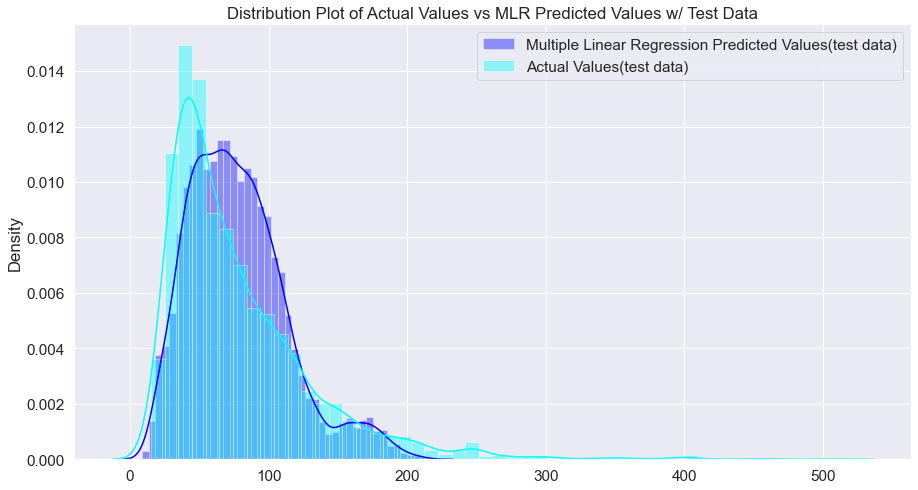

In [61]:
#distribution plot 
plt.figure(figsize=(15,8))
ax1 = sns.distplot(MLR_ypred, hist = True, color = 'blue', label = 'Multiple Linear Regression Predicted Values(test data)')
ax1 = sns.distplot(y_test, hist = True, color = 'cyan', label = 'Actual Values(test data)')
plt.title('Distribution Plot of Actual Values vs MLR Predicted Values w/ Test Data')
plt.legend()
plt.show()

### Polynomial Regression
The plot below shows the density distribution of actual (grey) and Polynomial Regression predicted (green) earnings values from the final test.

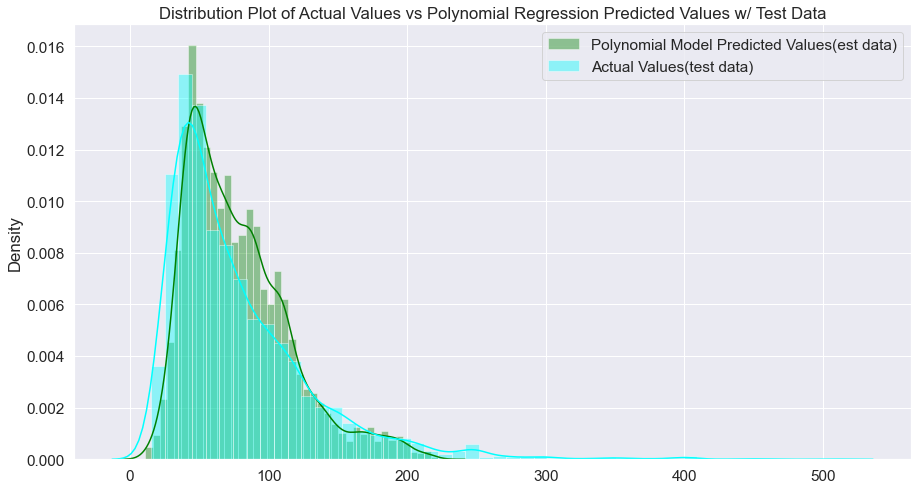

In [62]:
#distribution plot 
plt.figure(figsize=(15,8))
ax1 = sns.distplot(PR_ypred, hist = True, color = 'green', label = 'Polynomial Model Predicted Values(est data)')
ax1 = sns.distplot(y_test, hist = True, color = 'cyan', label = 'Actual Values(test data)')
plt.title('Distribution Plot of Actual Values vs Polynomial Regression Predicted Values w/ Test Data')
plt.legend()
plt.show()

### K-Neighbor Regressor
The plot below shows the density distribution of actual (grey) and K-Neighbor Regressor predicted (orange) earnings values from the final test.

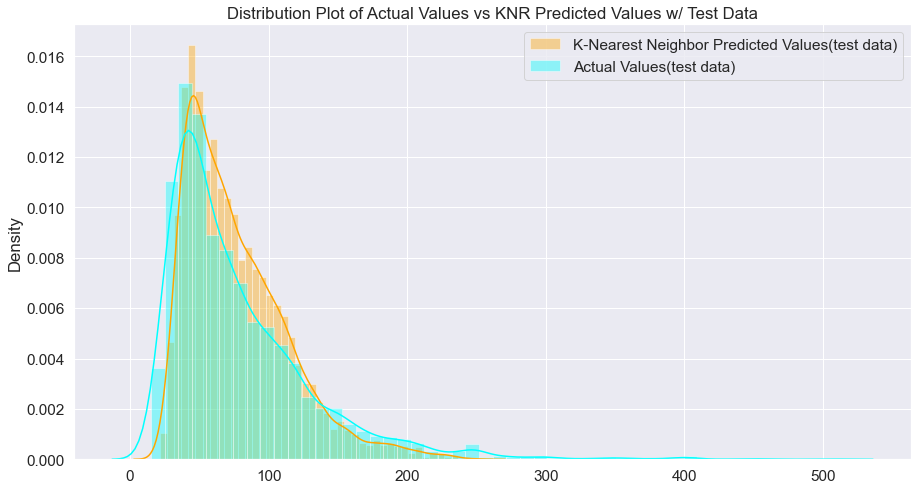

In [63]:
#distribution plot 
plt.figure(figsize=(15,8))
ax1 = sns.distplot(KNN_ypred, hist = True, color = 'orange', label = 'K-Nearest Neighbor Predicted Values(test data)')
ax1 = sns.distplot(y_test, hist = True, color = 'cyan', label = 'Actual Values(test data)')
plt.title('Distribution Plot of Actual Values vs KNR Predicted Values w/ Test Data')
plt.legend()
plt.show()

### Random Forest Regressor 
The plot below shows the density distribution of actual (grey) and Random Forest Regression predicted (pink) earnings values from the final test.

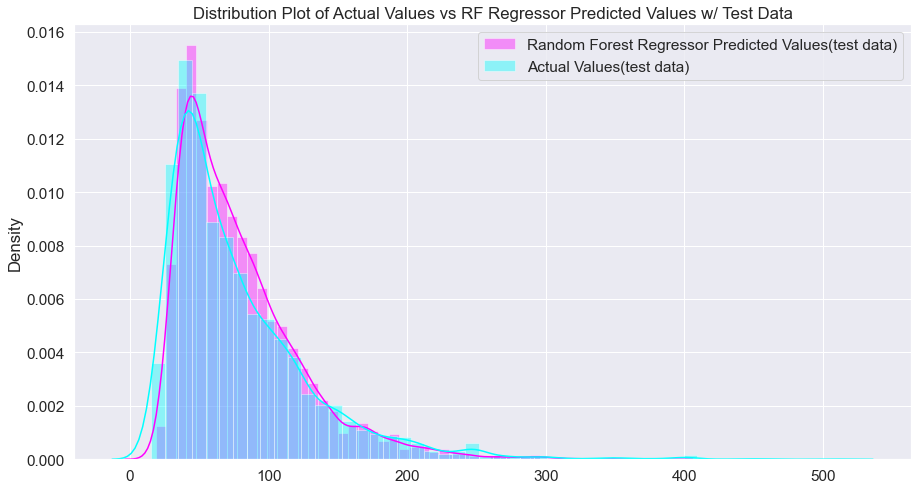

In [64]:
#distribution plot 
plt.figure(figsize=(15,8))
ax1 = sns.distplot(RF_ypred, hist = True, color = 'magenta', label = 'Random Forest Regressor Predicted Values(test data)')
ax1 = sns.distplot(y_test, hist = True, color = 'cyan', label = 'Actual Values(test data)')
plt.title('Distribution Plot of Actual Values vs RF Regressor Predicted Values w/ Test Data')
plt.legend()
plt.show()

### Ridge Regression
The plot below shows the density distribution of actual (grey) and Ridge Regression predicted (red) earnings values from the final test.

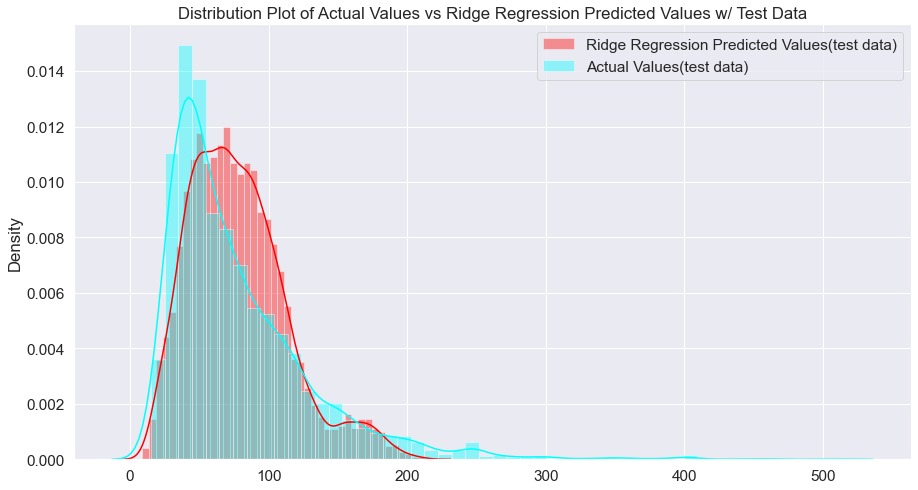

In [65]:
#distribution plot 
plt.figure(figsize=(15,8))
ax1 = sns.distplot(ridge_ypred, hist = True, color = 'red', label = 'Ridge Regression Predicted Values(test data)')
ax1 = sns.distplot(y_test, hist = True, color = 'cyan', label = 'Actual Values(test data)')
plt.title('Distribution Plot of Actual Values vs Ridge Regression Predicted Values w/ Test Data')
plt.legend()
plt.show()

### Lasso Regression
The plot below shows the density distribution of actual (grey) and Lasso Regression predicted (purple) earnings values from the final test.

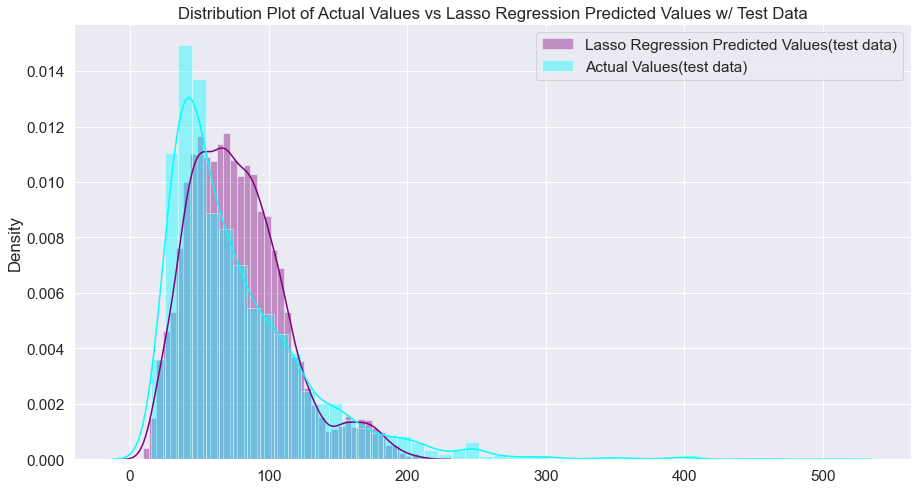

In [66]:
#distribution plot 
plt.figure(figsize=(15,8))
ax1 = sns.distplot(lasso_ypred, hist = True, color = 'purple', label = 'Lasso Regression Predicted Values(test data)')
ax1 = sns.distplot(y_test, hist = True, color = 'cyan', label = 'Actual Values(test data)')
plt.title('Distribution Plot of Actual Values vs Lasso Regression Predicted Values w/ Test Data')
plt.legend()
plt.show()

# Conclusion:
A Random Forest Regressor algorithm using the ordinal encoding of categorical features performed the best across all models and all performance metrics. 

Since the earnings variable is represented in thousands of USD, the performance results from the Random Forest Regression are to be interpreted as follows:
- The Mean Squared Error of this model is 1,357,110
- The Mean Absolute Error of this model is 18,610 
- The Root Mean Squared Error of this model is 36,840
- 51 percent of the variation in outcome can be explained by the variation in the independent variables
